## The Effect of Social Media Sentiments on Driver Performance
### Stephen Blough (bloughst), Shriya Ejanthker (shriyase), Elysia Pil (epil)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import warnings

warnings.simplefilter("ignore")

## Race Data Preprocessing & Manipulation

In [ ]:
drivers = pd.read_csv("data/drivers.csv")
teams = pd.read_csv("data/constructors.csv")
results = pd.read_csv("data/results.csv")
races = pd.read_csv("data/races.csv")
circuits = pd.read_csv("data/circuits.csv")
driver_standings = pd.read_csv("data/driver_standings.csv")
status = pd.read_csv("data/status.csv")

### Extract race data from the time period from which we will analyse tweets

In [ ]:
races["date"] = pd.to_datetime(races["date"])
start_date = "2021-07-18"
end_date = "2022-08-20"

races = races[(races["date"] >= start_date) & (races["date"] <= end_date)]
races.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
1036,1074,2022,1,3,Bahrain Grand Prix,2022-03-20,15:00:00,http://en.wikipedia.org/wiki/2022_Bahrain_Gran...,2022-03-18,12:00:00,2022-03-18,15:00:00,2022-03-19,12:00:00,2022-03-19,15:00:00,\N,\N
1038,1051,2021,20,78,Qatar Grand Prix,2021-11-21,14:00:00,http://en.wikipedia.org/wiki/2021_Qatar_Grand_...,2021-11-19,\N,2021-11-19,\N,2021-11-20,\N,2021-11-20,\N,\N,\N
1046,1061,2021,10,9,British Grand Prix,2021-07-18,14:00:00,http://en.wikipedia.org/wiki/2021_British_Gran...,2021-07-16,\N,2021-07-17,\N,\N,\N,2021-07-16,\N,2021-07-17,\N
1047,1062,2021,11,11,Hungarian Grand Prix,2021-08-01,13:00:00,http://en.wikipedia.org/wiki/2021_Hungarian_Gr...,2021-07-30,\N,2021-07-30,\N,2021-07-31,\N,2021-07-31,\N,\N,\N
1048,1063,2021,12,13,Belgian Grand Prix,2021-08-29,13:00:00,http://en.wikipedia.org/wiki/2021_Belgian_Gran...,2021-08-27,\N,2021-08-27,\N,2021-08-28,\N,2021-08-28,\N,\N,\N


#### Record the previous race's date and time as well for future use

In [ ]:
import datetime as dt

race_filtered = races[["raceId", "name", "date", "time", "quali_date", "year"]]
race_filtered = race_filtered.sort_values(by=["date"])
race_filtered["prev_date"] = race_filtered.date.shift(1)
race_filtered["prev_time"] = race_filtered.time.shift(1)
race_filtered.loc[1047, "prev_date"] = dt.datetime(2021, 7, 24)
race_filtered.loc[1047, "prev_time"] = "00:00:00"
race_filtered.head()

,raceId,name,date,time,quali_date,year,prev_date,prev_time
1046,1061,British Grand Prix,2021-07-18,14:00:00,2021-07-16,2021,NaT,NaN
1047,1062,Hungarian Grand Prix,2021-08-01,13:00:00,2021-07-31,2021,2021-07-24,00:00:00
1048,1063,Belgian Grand Prix,2021-08-29,13:00:00,2021-08-28,2021,2021-08-01,13:00:00
1049,1064,Dutch Grand Prix,2021-09-05,13:00:00,2021-09-04,2021,2021-08-29,13:00:00
1050,1065,Italian Grand Prix,2021-09-12,13:00:00,2021-09-10,2021,2021-09-05,13:00:00


In [ ]:
race_filtered.tail()

,raceId,name,date,time,quali_date,year,prev_date,prev_time
1065,1082,Canadian Grand Prix,2022-06-19,18:00:00,2022-06-18,2022,2022-06-12,11:00:00
1066,1083,British Grand Prix,2022-07-03,14:00:00,2022-07-02,2022,2022-06-19,18:00:00
1067,1084,Austrian Grand Prix,2022-07-10,13:00:00,2022-07-08,2022,2022-07-03,14:00:00
1068,1085,French Grand Prix,2022-07-24,13:00:00,2022-07-23,2022,2022-07-10,13:00:00
1069,1086,Hungarian Grand Prix,2022-07-31,13:00:00,2022-07-30,2022,2022-07-24,13:00:00


In [ ]:
results = results[(results["raceId"].isin(race_filtered["raceId"]))]

# arrange in required order
results_filtered = results[
    [
        "raceId",
        "driverId",
        "constructorId",
        "grid",
        "position",
        "positionOrder",
        "points",
        "time",
        "milliseconds",
        "fastestLapTime",
        "fastestLapSpeed",
        "statusId",
    ]
]
# results_filtered.info()

In [ ]:
drivers = drivers[(drivers["driverId"].isin(results["driverId"]))]
drivers_filtered = drivers[["driverId", "driverRef", "code"]]
drivers_filtered.head()

,driverId,driverRef,code
0,1,hamilton,HAM
3,4,alonso,ALO
7,8,raikkonen,RAI
8,9,kubica,KUB
19,20,vettel,VET


In [ ]:
teams = teams[(teams["constructorId"].isin(results["constructorId"]))]
teams_filtered = teams[["constructorId", "constructorRef"]]
# teams_filtered.info()

#### Merging all the datasets together

In [ ]:
race_data = pd.merge(race_filtered, results_filtered, on="raceId", how="outer")
race_data.head()

,raceId,name,date,time_x,quali_date,year,prev_date,prev_time,driverId,constructorId,grid,position,positionOrder,points,time_y,milliseconds,fastestLapTime,fastestLapSpeed,statusId
0,1061,British Grand Prix,2021-07-18,14:00:00,2021-07-16,2021,NaT,NaN,1,131,2,1,1,25.0,1:58:23.284,7103284,1:29.699,236.430,1
1,1061,British Grand Prix,2021-07-18,14:00:00,2021-07-16,2021,NaT,NaN,844,6,4,2,2,18.0,+3.871,7107155,1:30.569,234.159,1
2,1061,British Grand Prix,2021-07-18,14:00:00,2021-07-16,2021,NaT,NaN,822,131,3,3,3,15.0,+11.125,7114409,1:30.524,234.275,1
3,1061,British Grand Prix,2021-07-18,14:00:00,2021-07-16,2021,NaT,NaN,846,1,5,4,4,12.0,+28.573,7131857,1:31.420,231.979,1
4,1061,British Grand Prix,2021-07-18,14:00:00,2021-07-16,2021,NaT,NaN,817,1,6,5,5,10.0,+42.624,7145908,1:31.284,232.325,1


In [ ]:
race_data = race_data.merge(drivers_filtered, on="driverId", how="outer")

In [ ]:
race_data = pd.merge(race_data, teams_filtered, on="constructorId", how="outer")
# race_data.info()

In [ ]:
status.head()  # denotes status of driver in the race

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine


In [ ]:
race_data = race_data.merge(status, on="statusId", how="left")
# race_data.info()

In [ ]:
# race_data["status"].value_counts()

In [ ]:
race_data.head()

,raceId,name,date,time_x,quali_date,year,prev_date,prev_time,driverId,constructorId,...,points,time_y,milliseconds,fastestLapTime,fastestLapSpeed,statusId,driverRef,code,constructorRef,status
0,1061,British Grand Prix,2021-07-18,14:00:00,2021-07-16,2021,NaT,NaN,1,131,...,25.0,1:58:23.284,7103284,1:29.699,236.430,1,hamilton,HAM,mercedes,Finished
1,1062,Hungarian Grand Prix,2021-08-01,13:00:00,2021-07-31,2021,2021-07-24,00:00:00,1,131,...,18.0,+2.736,7485935,1:18.715,200.363,1,hamilton,HAM,mercedes,Finished
2,1063,Belgian Grand Prix,2021-08-29,13:00:00,2021-08-28,2021,2021-08-01,13:00:00,1,131,...,7.5,+2.601,209672,\N,\N,1,hamilton,HAM,mercedes,Finished
3,1064,Dutch Grand Prix,2021-09-05,13:00:00,2021-09-04,2021,2021-08-29,13:00:00,1,131,...,19.0,+20.932,5426327,1:11.097,215.654,1,hamilton,HAM,mercedes,Finished
4,1065,Italian Grand Prix,2021-09-12,13:00:00,2021-09-10,2021,2021-09-05,13:00:00,1,131,...,0.0,\N,\N,1:25.870,242.864,4,hamilton,HAM,mercedes,Collision


In [ ]:
race_data = race_data[  # changing order of columns
    [
        "raceId",
        "name",
        "date",
        "time_x",
        "driverId",
        "driverRef",
        "code",
        "constructorId",
        "constructorRef",
        "grid",
        "position",
        "positionOrder",
        "points",
        "time_y",
        "milliseconds",
        "fastestLapTime",
        "fastestLapSpeed",
        "statusId",
        "status",
        "year",
        "prev_date",
        "prev_time",
        "quali_date",
    ]
].reset_index(drop=True)

In [ ]:
race_data[race_data["status"] == "+1 Lap"].head()

,raceId,name,date,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,time_y,milliseconds,fastestLapTime,fastestLapSpeed,statusId,status,year,prev_date,prev_time,quali_date
16,1077,Emilia Romagna Grand Prix,2022-04-24,13:00:00,1,hamilton,HAM,131,mercedes,14,...,\N,\N,1:21.419,217.054,11,+1 Lap,2022,2022-04-10,05:00:00,2022-04-22
55,1064,Dutch Grand Prix,2021-09-05,13:00:00,844,leclerc,LEC,6,ferrari,5,...,\N,\N,1:14.780,205.033,11,+1 Lap,2021,2021-08-29,13:00:00,2021-09-04
57,1066,Russian Grand Prix,2021-09-26,12:00:00,844,leclerc,LEC,6,ferrari,19,...,\N,\N,1:38.994,212.667,11,+1 Lap,2021,2021-09-12,13:00:00,2021-09-25
81,1064,Dutch Grand Prix,2021-09-05,13:00:00,832,sainz,SAI,6,ferrari,6,...,\N,\N,1:15.260,203.725,11,+1 Lap,2021,2021-08-29,13:00:00,2021-09-04
86,1070,Mexico City Grand Prix,2021-11-07,19:00:00,832,sainz,SAI,6,ferrari,6,...,\N,\N,1:20.081,193.484,11,+1 Lap,2021,2021-10-24,19:00:00,2021-11-06


For the purpose of our analysis, change the status of +1 Lap, +2 Lap, +3 Lap, etc. to "Finished" as they essentially mean the drivers finished the race but were behind the race leader by the mentioned number of laps 

In [ ]:
race_data.loc[
    race_data["status"].isin(
        ["+1 Lap", "+2 Lap", "+3 Lap", "+4 Lap", "+5 Lap", "+6 Lap", "+7 Lap", "+8 Lap"]
    ),
    "status",
] = "Finished"

### Manipulating race data and EDA

In [ ]:
race_data.describe()

,raceId,driverId,constructorId,grid,positionOrder,points,statusId,year
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,1072.846154,696.480769,95.500000,10.003846,10.500000,4.997115,11.725000,2021.500000
std,8.618179,313.360343,88.198694,5.869485,5.771834,7.178396,27.383513,0.500481
min,1051.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2021.000000
25%,1066.000000,817.000000,6.000000,5.000000,5.750000,0.000000,1.000000,2021.000000
50%,1073.500000,839.500000,84.000000,10.000000,10.500000,0.250000,1.000000,2021.500000
75%,1080.000000,847.000000,210.000000,15.000000,15.250000,8.000000,11.000000,2022.000000
max,1086.000000,855.000000,214.000000,20.000000,20.000000,26.000000,141.000000,2022.000000


In [ ]:
# race_data.info()

In [ ]:
race_data.head()

,raceId,name,date,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,time_y,milliseconds,fastestLapTime,fastestLapSpeed,statusId,status,year,prev_date,prev_time,quali_date
0,1061,British Grand Prix,2021-07-18,14:00:00,1,hamilton,HAM,131,mercedes,2,...,1:58:23.284,7103284,1:29.699,236.430,1,Finished,2021,NaT,NaN,2021-07-16
1,1062,Hungarian Grand Prix,2021-08-01,13:00:00,1,hamilton,HAM,131,mercedes,1,...,+2.736,7485935,1:18.715,200.363,1,Finished,2021,2021-07-24,00:00:00,2021-07-31
2,1063,Belgian Grand Prix,2021-08-29,13:00:00,1,hamilton,HAM,131,mercedes,3,...,+2.601,209672,\N,\N,1,Finished,2021,2021-08-01,13:00:00,2021-08-28
3,1064,Dutch Grand Prix,2021-09-05,13:00:00,1,hamilton,HAM,131,mercedes,2,...,+20.932,5426327,1:11.097,215.654,1,Finished,2021,2021-08-29,13:00:00,2021-09-04
4,1065,Italian Grand Prix,2021-09-12,13:00:00,1,hamilton,HAM,131,mercedes,4,...,\N,\N,1:25.870,242.864,4,Collision,2021,2021-09-05,13:00:00,2021-09-10


Formatting columns in the dataset and finding missing values 

In [ ]:
race_data["time_x"] = pd.to_datetime(race_data["time_x"], format="%H:%M:%S").dt.time
race_data["statusId"] = race_data["statusId"].astype(object)
race_data["year"] = pd.to_datetime(race_data["year"], format="%Y").dt.year
race_data["quali_date"] = pd.to_datetime(race_data["quali_date"], format="%Y-%m-%d")
race_data["prev_time"] = pd.to_datetime(
    race_data["prev_time"], format="%H:%M:%S"
).dt.time

In [ ]:
race_data["milliseconds"] = race_data["milliseconds"].replace("\\N", np.nan)

In [ ]:
race_data["fastestLapTime"] = race_data["fastestLapTime"].replace("\\N", np.nan)
race_data["fastestLapTime"] = pd.to_datetime(
    race_data["fastestLapTime"], format="%M:%S.%f"
).dt.time
race_data["fastestLapSpeed"] = race_data["fastestLapSpeed"].replace("\\N", np.nan)
race_data["fastestLapSpeed"] = race_data["fastestLapSpeed"].astype(float)
# race_data.info()

Missing values in the exist for races where the drivers never finished the race. It means they had either car issues or an accident. So we shall not fill in the missing values and preserve the data as it is.

In [ ]:
race_data = race_data.replace("\\N", np.nan)

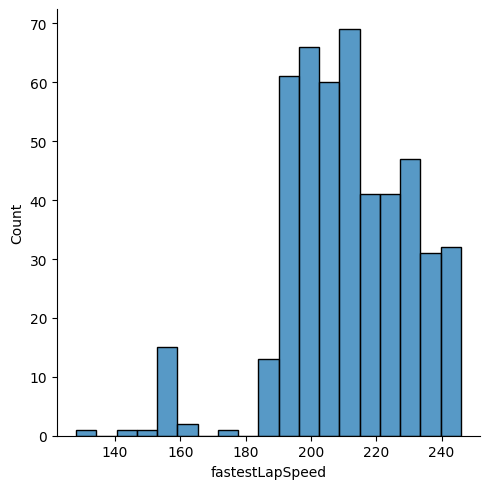

In [ ]:
sns.displot(race_data["fastestLapSpeed"])

To estimate a driver's performance for a race with respect to their usual performance, we shall estimate their average finish position throughout the season, not counting race-car failure. 

In [ ]:
# average position of the drivers in 2021
avg_position_2021 = (
    race_data.loc[
        (
            race_data["status"].isin(
                [
                    "Finished",
                    "Collision",
                    "Accident",
                    "Collision damage",
                ]  # excludes races with car-failure
            )
        )
        & (race_data["year"] == 2021)
    ]
    .groupby("driverRef")[
        "positionOrder"
    ]  # positionOrder tells us the final rank of the drivers
    .mean()
    .sort_values(ascending=True)
    .reset_index()
)
avg_position_2021.rename(columns={"positionOrder": "avg_position"}, inplace=True)
avg_position_2021.head()

,driverRef,avg_position
0,hamilton,3.076923
1,max_verstappen,4.769231
2,bottas,5.545455
3,sainz,6.153846
4,gasly,7.090909


In 2021, Hamilton had the highest average position followed by Verstappen and Bottas.

<Axes: xlabel='avg_position', ylabel='driverRef'>

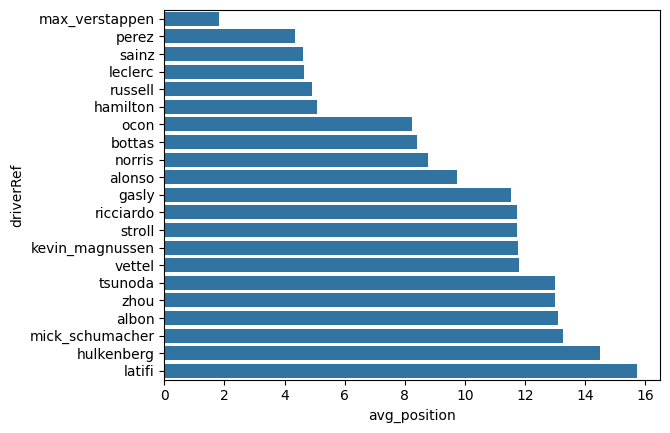

In [ ]:
# average position of drivers in 2022
avg_position_2022 = (
    race_data.loc[
        (
            race_data["status"].isin(
                ["Finished", "Collision", "Accident", "Collision damage"]
            )
        )
        & (race_data["year"] == 2022)
    ]
    .groupby("driverRef")["positionOrder"]
    .mean()
    .sort_values(ascending=True)
    .reset_index()
)
avg_position_2022.rename(columns={"positionOrder": "avg_position"}, inplace=True)
sns.barplot(x="avg_position", y="driverRef", data=avg_position_2022)

In 2022, Verstappen had the highest position followed by Perez and Sainz.

In [ ]:
avg_position_2022.head()

,driverRef,avg_position
0,max_verstappen,1.818182
1,perez,4.363636
2,sainz,4.600000
3,leclerc,4.636364
4,russell,4.923077


Calculate change in finish position and speed of drivers for each race with respect to their average position and speed for the season

In [ ]:
# Calculate position relative to their usual position
race_data["relative_position"] = np.where(
    race_data["year"] == 2021,
    race_data.merge(avg_position_2021, on="driverRef")["avg_position"]
    - race_data["positionOrder"],
    race_data.merge(avg_position_2022, on="driverRef")["avg_position"]
    - race_data["positionOrder"],
)
race_data.head()

,raceId,name,date,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,milliseconds,fastestLapTime,fastestLapSpeed,statusId,status,year,prev_date,prev_time,quali_date,relative_position
0,1061,British Grand Prix,2021-07-18,14:00:00,1,hamilton,HAM,131,mercedes,2,...,7103284,00:01:29.699000,236.430,1,Finished,2021,NaT,NaT,2021-07-16,2.076923
1,1062,Hungarian Grand Prix,2021-08-01,13:00:00,1,hamilton,HAM,131,mercedes,1,...,7485935,00:01:18.715000,200.363,1,Finished,2021,2021-07-24,00:00:00,2021-07-31,1.076923
2,1063,Belgian Grand Prix,2021-08-29,13:00:00,1,hamilton,HAM,131,mercedes,3,...,209672,NaT,NaN,1,Finished,2021,2021-08-01,13:00:00,2021-08-28,0.076923
3,1064,Dutch Grand Prix,2021-09-05,13:00:00,1,hamilton,HAM,131,mercedes,2,...,5426327,00:01:11.097000,215.654,1,Finished,2021,2021-08-29,13:00:00,2021-09-04,1.076923
4,1065,Italian Grand Prix,2021-09-12,13:00:00,1,hamilton,HAM,131,mercedes,4,...,NaN,00:01:25.870000,242.864,4,Collision,2021,2021-09-05,13:00:00,2021-09-10,-13.923077


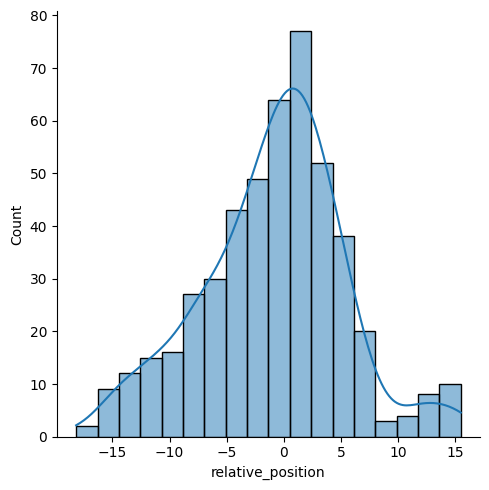

In [ ]:
sns.displot(race_data["relative_position"], kde=True)

Relative position for the drivers follows a normal distribution, as expected.

In [ ]:
race_data["date"] = pd.to_datetime(race_data["date"])
# sorting data

race_data = race_data.sort_values(
    by=[
        "driverRef",
        "date",
    ],
    ascending=True,
)
race_data.head()

,raceId,name,date,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,milliseconds,fastestLapTime,fastestLapSpeed,statusId,status,year,prev_date,prev_time,quali_date,relative_position
403,1074,Bahrain Grand Prix,2022-03-20,15:00:00,848,albon,ALB,3,williams,14,...,5907516,00:01:37.355000,200.125,1,Finished,2022,2021-12-12,13:00:00,2022-03-19,-8.636364
404,1075,Saudi Arabian Grand Prix,2022-03-27,17:00:00,848,albon,ALB,3,williams,16,...,NaN,00:01:34.368000,235.528,130,Collision damage,2022,2022-03-20,15:00:00,2022-03-26,-9.636364
405,1076,Australian Grand Prix,2022-04-10,05:00:00,848,albon,ALB,3,williams,20,...,5345930,00:01:22.589000,230.064,1,Finished,2022,2022-03-27,17:00:00,2022-04-09,-5.636364
406,1077,Emilia Romagna Grand Prix,2022-04-24,13:00:00,848,albon,ALB,3,williams,18,...,NaN,00:01:21.757000,216.157,11,Finished,2022,2022-04-10,05:00:00,2022-04-22,-6.636364
407,1078,Miami Grand Prix,2022-05-08,19:30:00,848,albon,ALB,3,williams,18,...,5696623,00:01:33.447000,208.494,1,Finished,2022,2022-04-24,13:00:00,2022-05-07,-4.636364


In [ ]:
# Calculate average speed
avg_speed_2021 = (
    race_data.loc[(race_data["year"] == 2021)]
    .groupby("driverRef")["fastestLapSpeed"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
avg_speed_2021.rename(columns={"fastestLapSpeed": "avg_fastestLapSpeed"}, inplace=True)
avg_speed_2021.head()

,driverRef,avg_fastestLapSpeed
0,kubica,223.079000
1,bottas,219.419909
2,perez,218.913818
3,hamilton,218.455083
4,norris,217.749909


In [ ]:
avg_speed_2022 = (
    race_data.loc[(race_data["year"] == 2022)]
    .groupby("driverRef")["fastestLapSpeed"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
avg_speed_2022.rename(columns={"fastestLapSpeed": "avg_fastestLapSpeed"}, inplace=True)
avg_speed_2022.head()

,driverRef,avg_fastestLapSpeed
0,hulkenberg,217.866500
1,leclerc,211.685615
2,max_verstappen,211.665769
3,perez,210.211385
4,hamilton,210.175154


In [ ]:
# Calculate difference in fastest lap speed
race_data["relative_fastestLapSpeed"] = np.where(
    race_data["year"] == 2021,
    race_data["fastestLapSpeed"]
    - race_data.merge(avg_speed_2021, on="driverRef")["avg_fastestLapSpeed"],
    race_data["fastestLapSpeed"]
    - race_data.merge(avg_speed_2022, on="driverRef")["avg_fastestLapSpeed"],
)
race_data.head(3).T

,403,404,405
raceId,1074,1075,1076
name,Bahrain Grand Prix,Saudi Arabian Grand Prix,Australian Grand Prix
date,2022-03-20 00:00:00,2022-03-27 00:00:00,2022-04-10 00:00:00
time_x,15:00:00,17:00:00,05:00:00
driverId,848,848,848
driverRef,albon,albon,albon
code,ALB,ALB,ALB
constructorId,3,3,3
constructorRef,williams,williams,williams
grid,14,16,20


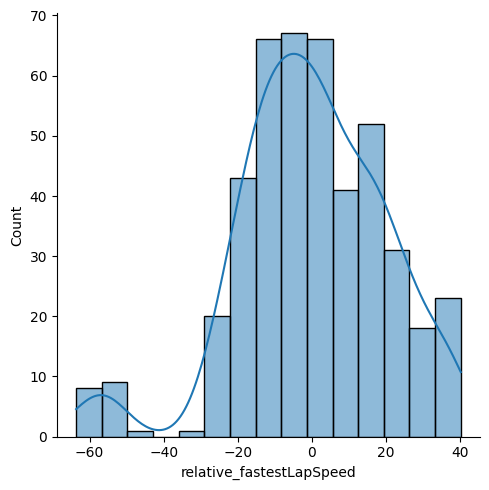

In [ ]:
sns.displot(race_data["relative_fastestLapSpeed"], kde=True)

Now calculate improvement in performance of drivers with respect to their last race

In [ ]:
race_data["positionGain"] = np.where(
    race_data["driverRef"] == race_data["driverRef"].shift(1),
    -race_data["positionOrder"] + race_data["positionOrder"].shift(1),
    0,
)
race_data.head()

,raceId,name,date,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,fastestLapSpeed,statusId,status,year,prev_date,prev_time,quali_date,relative_position,relative_fastestLapSpeed,positionGain
403,1074,Bahrain Grand Prix,2022-03-20,15:00:00,848,albon,ALB,3,williams,14,...,200.125,1,Finished,2022,2021-12-12,13:00:00,2022-03-19,-8.636364,31.297667,0.0
404,1075,Saudi Arabian Grand Prix,2022-03-27,17:00:00,848,albon,ALB,3,williams,16,...,235.528,130,Collision damage,2022,2022-03-20,15:00:00,2022-03-26,-9.636364,-4.769333,-1.0
405,1076,Australian Grand Prix,2022-04-10,05:00:00,848,albon,ALB,3,williams,20,...,230.064,1,Finished,2022,2022-03-27,17:00:00,2022-04-09,-5.636364,NaN,4.0
406,1077,Emilia Romagna Grand Prix,2022-04-24,13:00:00,848,albon,ALB,3,williams,18,...,216.157,11,Finished,2022,2022-04-10,05:00:00,2022-04-22,-6.636364,10.521667,-1.0
407,1078,Miami Grand Prix,2022-05-08,19:30:00,848,albon,ALB,3,williams,18,...,208.494,1,Finished,2022,2022-04-24,13:00:00,2022-05-07,-4.636364,37.731667,2.0


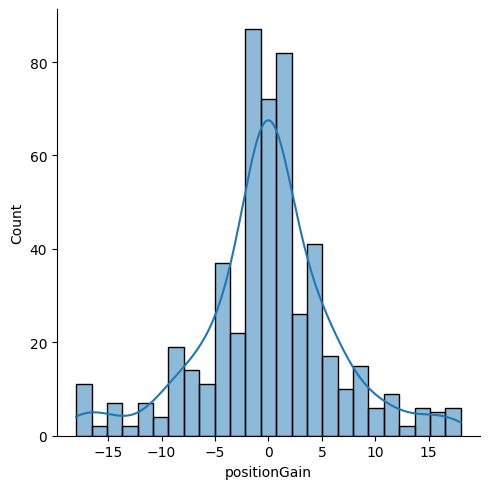

In [ ]:
sns.displot(race_data["positionGain"], kde=True)

positionGain has a normal distribution, which indicates drivers equally performed better and worse in their races

In [ ]:
# Calculate prev position and difference in fastest lap speed
race_data["prev_position"] = np.where(
    race_data["driverRef"] == race_data["driverRef"].shift(1),
    race_data["positionOrder"].shift(1),
    np.nan,
)
race_data["fastestSpeedGain"] = np.where(
    race_data["driverRef"] == race_data["driverRef"].shift(1),
    race_data["fastestLapSpeed"] - race_data["fastestLapSpeed"].shift(1),
    np.nan,
)
race_data.head()

,raceId,name,date,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,status,year,prev_date,prev_time,quali_date,relative_position,relative_fastestLapSpeed,positionGain,prev_position,fastestSpeedGain
403,1074,Bahrain Grand Prix,2022-03-20,15:00:00,848,albon,ALB,3,williams,14,...,Finished,2022,2021-12-12,13:00:00,2022-03-19,-8.636364,31.297667,0.0,NaN,NaN
404,1075,Saudi Arabian Grand Prix,2022-03-27,17:00:00,848,albon,ALB,3,williams,16,...,Collision damage,2022,2022-03-20,15:00:00,2022-03-26,-9.636364,-4.769333,-1.0,13.0,35.403
405,1076,Australian Grand Prix,2022-04-10,05:00:00,848,albon,ALB,3,williams,20,...,Finished,2022,2022-03-27,17:00:00,2022-04-09,-5.636364,NaN,4.0,14.0,-5.464
406,1077,Emilia Romagna Grand Prix,2022-04-24,13:00:00,848,albon,ALB,3,williams,18,...,Finished,2022,2022-04-10,05:00:00,2022-04-22,-6.636364,10.521667,-1.0,10.0,-13.907
407,1078,Miami Grand Prix,2022-05-08,19:30:00,848,albon,ALB,3,williams,18,...,Finished,2022,2022-04-24,13:00:00,2022-05-07,-4.636364,37.731667,2.0,11.0,-7.663


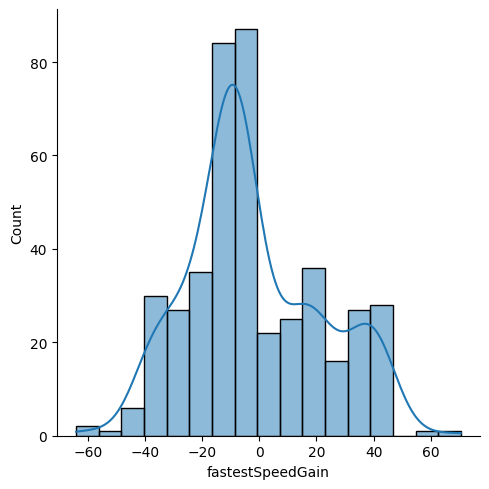

In [ ]:
sns.displot(race_data["fastestSpeedGain"], kde=True)

Calculate difference in final and start position to assess performance during the race

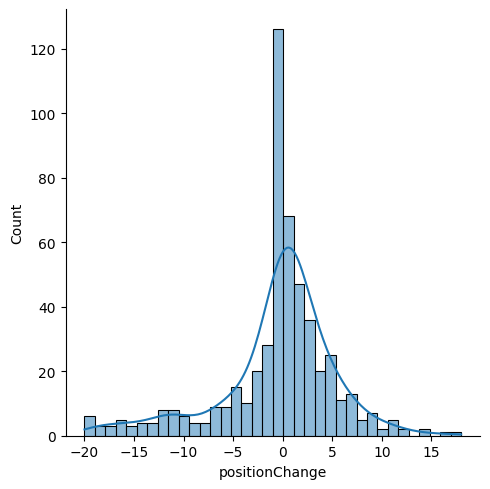

In [ ]:
race_data["positionChange"] = race_data["grid"] - race_data["positionOrder"]
sns.displot(race_data["positionChange"], kde=True)

In [ ]:
# drop 2021 British GP as tweet data is only available from after the race
race_data.drop(race_data[race_data["raceId"] == 1061].index, inplace=True)
race_data.head()

,raceId,name,date,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,year,prev_date,prev_time,quali_date,relative_position,relative_fastestLapSpeed,positionGain,prev_position,fastestSpeedGain,positionChange
403,1074,Bahrain Grand Prix,2022-03-20,15:00:00,848,albon,ALB,3,williams,14,...,2022,2021-12-12,13:00:00,2022-03-19,-8.636364,31.297667,0.0,NaN,NaN,1
404,1075,Saudi Arabian Grand Prix,2022-03-27,17:00:00,848,albon,ALB,3,williams,16,...,2022,2022-03-20,15:00:00,2022-03-26,-9.636364,-4.769333,-1.0,13.0,35.403,2
405,1076,Australian Grand Prix,2022-04-10,05:00:00,848,albon,ALB,3,williams,20,...,2022,2022-03-27,17:00:00,2022-04-09,-5.636364,NaN,4.0,14.0,-5.464,10
406,1077,Emilia Romagna Grand Prix,2022-04-24,13:00:00,848,albon,ALB,3,williams,18,...,2022,2022-04-10,05:00:00,2022-04-22,-6.636364,10.521667,-1.0,10.0,-13.907,7
407,1078,Miami Grand Prix,2022-05-08,19:30:00,848,albon,ALB,3,williams,18,...,2022,2022-04-24,13:00:00,2022-05-07,-4.636364,37.731667,2.0,11.0,-7.663,9


Adding categorical race statistics

In [ ]:
race_data["finished"] = np.where(race_data["status"] == "Finished", 1, 0)
race_data["wonPoints"] = np.where(race_data["points"] > 0, 1, 0)
race_data["crashed"] = np.where(
    race_data["status"].isin(
        ["Collision", "Accident", "Collision", "Collision damage"]
    ),
    1,
    0,
)
race_data["carIssues"] = np.where(
    race_data["status"].isin(
        ["Finished", "Collision", "Accident", "Collision", "Collision damage"]
    ),
    0,
    1,
)

<Axes: xlabel='crashed', ylabel='driverRef'>

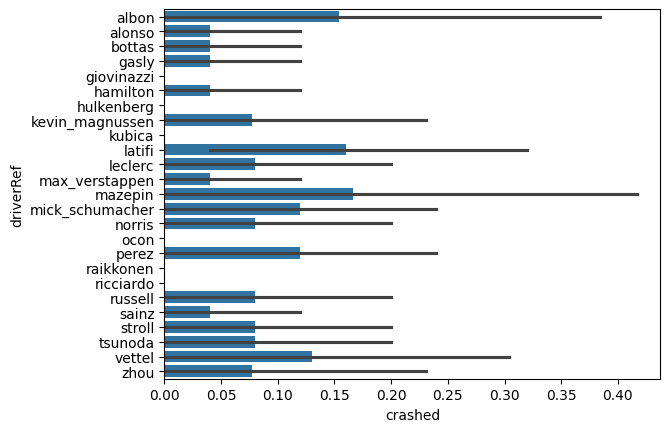

In [ ]:
sns.barplot(data=race_data, x="crashed", y="driverRef")

In [ ]:
# race_data.info()

## Tweet Data Preprocessing & Manipulation

### Read Data In and get the columns needed

In [ ]:
# load in tweet data
tweet_data = pd.read_csv("data/F1_tweets.csv", low_memory=False)
tweet_data.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,Zack Shephard,NaN,My opinions are mine ALONE. Venting is the onl...,2011-12-03 20:36:55,89.0,2598,212886,False,2021-08-01 23:59:18,The next great #F1 duo!!! @ESPNF1 https://t.co...,['F1'],Twitter for iPhone,False
1,Matteo Vannucci,NaN,"Free speech, free ideas, random thoughts",2010-05-28 01:02:32,10.0,40,8,False,2021-08-01 23:59:10,@F1 What if…Hamilton would have gone to the pi...,"['HungarianGP', 'F1']",Twitter for iPhone,False
2,Michelle,The Burbs,"likes- movies, candy, being lazy, formula 1, ...",2009-03-04 16:53:13,231.0,110,428,False,2021-08-01 23:58:48,This has been a tiring #f1 day... https://t.co...,['f1'],Twitter for Android,False
3,JoshWFC 🇧🇷,NaN,| JP10’s biggest fan | pronouns : João/Pedro |...,2021-04-05 16:14:53,156.0,443,2994,False,2021-08-01 23:58:11,Valteri Bottass tracking down Max Verstappen o...,['F1'],Twitter for iPhone,False
4,Ria Tagulinao,MNL,Fun-sized Filipina writer @Medium,2009-06-22 16:08:51,833.0,379,30891,False,2021-08-01 23:57:40,No words to describe the #HungarianGP so I wil...,"['HungarianGP', 'F1']",Twitter for iPhone,False


In [ ]:
# only take the important columns from tweets
tweet_df = tweet_data[["user_followers", "date", "text"]]

In [ ]:
# convert date to datetime
tweet_df.loc[:, "date"] = pd.to_datetime(tweet_df["date"], errors="coerce")

In [ ]:
tweet_df.isna().sum()

user_followers    0
date              4
text              0
dtype: int64

In [ ]:
# drop rows with missing dates
tweet_df = tweet_df.dropna()

In [ ]:
tweet_df.date.min()

Timestamp('2021-07-25 01:37:44')

In [ ]:
tweet_df.date.max()

Timestamp('2022-08-20 23:59:09')

### Only grab the drivers that raced in the time frame of the data

In [ ]:
# read in driver data with only the drivers from 2021 and 2022 seasons
driver_df = drivers
# only need id, ref name, code, forename, surname
driver_df = driver_df[["driverId", "driverRef", "code", "forename", "surname"]]
driver_df.head()

,driverId,driverRef,code,forename,surname
0,1,hamilton,HAM,Lewis,Hamilton
3,4,alonso,ALO,Fernando,Alonso
7,8,raikkonen,RAI,Kimi,Räikkönen
8,9,kubica,KUB,Robert,Kubica
19,20,vettel,VET,Sebastian,Vettel


In [ ]:
driver_df.driverId.unique()

array([  1,   4,   8,   9,  20, 842, 807, 815, 817, 822, 825, 830, 832,
       839, 840, 841, 844, 846, 847, 848, 849, 852, 853, 854, 855])

#### Drivers with nickname id's

In [ ]:
# we need to track daniel ricciardo and sergio perez's id's because they have
# commonly used nicknames
ricciardo_id = driver_df[driver_df.driverRef == "ricciardo"].driverId.values[0]
perez_id = driver_df[driver_df.driverRef == "perez"].driverId.values[0]

In [ ]:
driver_df[driver_df.driverRef == "ricciardo"].driverId.values[0]

817

In [ ]:
driver_df[driver_df.driverId == ricciardo_id].forename

816    Daniel
Name: forename, dtype: object

In [ ]:
split = driver_df.driverRef.str.split("_", expand=True)
driver_df.loc[:, "driverRef"] = np.where(split[1].isna(), split[0], split[1])

In [ ]:
driver_df.head()

,driverId,driverRef,code,forename,surname
0,1,hamilton,HAM,Lewis,Hamilton
3,4,alonso,ALO,Fernando,Alonso
7,8,raikkonen,RAI,Kimi,Räikkönen
8,9,kubica,KUB,Robert,Kubica
19,20,vettel,VET,Sebastian,Vettel


### Defining a function to create a dictionary with each driver id, with the index of every tweet

In [ ]:
# clean the tweet data by removing special characters and punctuation
# and making all text lowercase
tweet_df.text = tweet_df.text.str.lower()
tweet_df.text = tweet_df.text.apply(lambda x: re.sub(r"[^\w\s]+", " ", x))

In [ ]:
tweet_df.head()

,user_followers,date,text
0,89.0,2021-08-01 23:59:18,the next great f1 duo espnf1 https t co wmh...
1,10.0,2021-08-01 23:59:10,f1 what if hamilton would have gone to the pi...
2,231.0,2021-08-01 23:58:48,this has been a tiring f1 day https t co 34g...
3,156.0,2021-08-01 23:58:11,valteri bottass tracking down max verstappen o...
4,833.0,2021-08-01 23:57:40,no words to describe the hungariangp so i wil...


In [ ]:
# defining a function to create a dataframe with the driverId's for each tweet
def create_driver_df(tweet_df, driver_df):
    # capture the structure of the tweet_df with a driver id and empty it
    tweet_df["driverId"] = np.empty(len(tweet_df), dtype=int)
    agg_df = tweet_df.iloc[0:0]
    # iterate through each driver and find the tweets that contain
    # their first name, code, or last name
    for driver_Id in driver_df["driverId"]:
        row = driver_df[driver_df["driverId"] == driver_Id]
        first_mask = tweet_df.text.str.contains(row["forename"].values[0].lower())
        first_name = tweet_df[first_mask]
        last_mask = tweet_df.text.str.contains(row["driverRef"].values[0].lower())
        last_name = tweet_df[last_mask]
        # now match by driver code
        code_mask = tweet_df.text.str.match(row["code"].values[0].lower())
        code = tweet_df[code_mask]
        # concat the dataframes for the matched tweets and add the driverId
        df = pd.concat([first_name, last_name, code])
        df["driverId"] = driver_Id
        # add the dataframe to the aggregate dataframe
        agg_df = pd.concat([agg_df, df]).drop_duplicates()
    # add matches in ricciardo and perez's nicknames to the dataframe
    ricc = tweet_df[tweet_df.text.str.contains("danny")]
    checo = tweet_df[tweet_df.text.str.contains("checo")]
    ricc.loc[:, "driverId"] = ricciardo_id
    checo.loc[:, "driverId"] = perez_id
    # aggregate everything and return
    agg_df = pd.concat([agg_df, ricc, checo]).drop_duplicates()
    return agg_df

In [ ]:
# call function
tweet_driver_df = create_driver_df(tweet_df, driver_df)

In [ ]:
tweet_driver_df.shape

(472848, 4)

In [ ]:
tweet_driver_df.head()

,user_followers,date,text,driverId
7,58.0,2021-08-01 23:55:18,breaking news fia has disqualified oconesteb...,1
21,653.0,2021-08-01 23:48:15,i don t even root for lh but these ppl booing ...,1
24,423.0,2021-08-01 23:47:24,heck of a race today lewishamilton with an u...,1
29,208.0,2021-08-01 23:44:03,dianagriekspoor f1 lewishamilton valtterib...,1
38,2197.0,2021-08-01 23:38:43,f1 esteban ocon won the hungarian grand prix ...,1


In [ ]:
# export file for kaggle sentiment analysis
import csv

tweet_driver_df.to_csv(
    "data/tweet_driver_df.csv", index=False, quoting=csv.QUOTE_NONNUMERIC
)

In [ ]:
tweet_driver_df.isna().sum()

user_followers    0
date              0
text              0
driverId          0
dtype: int64

## Tweet Data Sentiment Analysis (This section was run on Kaggle, takes ~5 hours)


In [ ]:
# import spacy for nlp
# import spacy

##loading up the language model: English
# nlp = spacy.load('en_core_web_sm')

In [ ]:
##loading in data from Kaggle
# tweet_driver_df = pd.read_csv('data/tweet_driver_df.csv')

In [ ]:
##Brief look at number of tweets per driver
# tweet_driver_df['driverId'].value_counts()

In [ ]:
# import nltk

##"VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool \
##     that is specifically attuned to sentiments expressed in social media."(Class Notebook Description)

# nltk.download('vader_lexicon')

In [ ]:
##This extends the spaCy functionality with the SentimentIntensityAnalyzer function from NLTK

# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# sent_analyzer = SentimentIntensityAnalyzer()
# def sentiment_scores(docx):
#     return sent_analyzer.polarity_scores(docx.text)

In [ ]:
##Extension used to create sentiment score

# from spacy.tokens import Doc
# Doc.set_extension("sentimenter",getter=sentiment_scores)

In [ ]:
##Applying sentiment analysis - compound sentiment score

# tweet_driver_df['compound_sentiment_rating'] = \
#    [nlp(tweet)._.sentimenter['compound']
#     for tweet in tweet_driver_df.text.astype(str)]

In [ ]:
##Applying sentiment analysis - positive sentiment score

# tweet_driver_df['pos_sentiment_rating'] = \
#    [nlp(tweet)._.sentimenter['pos']
#     for tweet in tweet_driver_df.text.astype(str)]

In [ ]:
##Applying sentiment analysis - negative sentiment score

# tweet_driver_df['neg_sentiment_rating'] = \
#    [nlp(tweet)._.sentimenter['neg']
#     for tweet in tweet_driver_df.text.astype(str)]

In [ ]:
##Exports results data frame in csv file

# tweet_driver_df.to_csv('data/tweets_sentiment.csv', index=False)

## Merging the tweet and race data

In [ ]:
# create copy of race data
merged_data = race_data.copy(deep=True)
merged_data.head()

,raceId,name,date,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,relative_position,relative_fastestLapSpeed,positionGain,prev_position,fastestSpeedGain,positionChange,finished,wonPoints,crashed,carIssues
403,1074,Bahrain Grand Prix,2022-03-20,15:00:00,848,albon,ALB,3,williams,14,...,-8.636364,31.297667,0.0,NaN,NaN,1,1,0,0,0
404,1075,Saudi Arabian Grand Prix,2022-03-27,17:00:00,848,albon,ALB,3,williams,16,...,-9.636364,-4.769333,-1.0,13.0,35.403,2,0,0,1,0
405,1076,Australian Grand Prix,2022-04-10,05:00:00,848,albon,ALB,3,williams,20,...,-5.636364,NaN,4.0,14.0,-5.464,10,1,1,0,0
406,1077,Emilia Romagna Grand Prix,2022-04-24,13:00:00,848,albon,ALB,3,williams,18,...,-6.636364,10.521667,-1.0,10.0,-13.907,7,1,0,0,0
407,1078,Miami Grand Prix,2022-05-08,19:30:00,848,albon,ALB,3,williams,18,...,-4.636364,37.731667,2.0,11.0,-7.663,9,1,1,0,0


In [ ]:
# convert date columns to datetime
merged_data["date"] = pd.to_datetime(merged_data["date"])
merged_data["prev_date"] = pd.to_datetime(merged_data["prev_date"])

In [ ]:
# join the date and the time columns into one datetime
merged_data["date"] = pd.to_timedelta(merged_data.time_x.astype(str)) + merged_data.date
merged_data["prev_date"] = (
    pd.to_timedelta(merged_data.prev_time.astype(str)) + merged_data.prev_date
)

In [ ]:
# read in tweet sentiments created in kaggle
tweets = pd.read_csv("data/tweets_sentiment.csv", low_memory=False)
tweets.head()

,user_followers,date,text,driverId,compound_sentiment_rating,pos_sentiment_rating,neg_sentiment_rating
0,58.0,2021-08-01 23:55:18,breaking news fia has disqualified oconesteb...,1.0,0.2500,0.143,0.105
1,653.0,2021-08-01 23:48:15,i don t even root for lh but these ppl booing ...,1.0,0.1879,0.074,0.060
2,423.0,2021-08-01 23:47:24,heck of a race today lewishamilton with an u...,1.0,0.9342,0.371,0.000
3,208.0,2021-08-01 23:44:03,dianagriekspoor f1 lewishamilton valtterib...,1.0,-0.8434,0.100,0.209
4,2197.0,2021-08-01 23:38:43,f1 esteban ocon won the hungarian grand prix ...,1.0,0.2846,0.122,0.079


In [ ]:
# there is a weird case with data writing across 3 rows
tweets[tweets.isna().any(axis=1)]

,user_followers,date,text,driverId,compound_sentiment_rating,pos_sentiment_rating,neg_sentiment_rating
249094,7.0,2021-11-07 20:57:32,f1 mexicogp the rules on fastest lap bonus p...,NaN,NaN,NaN,NaN
249095,lap time of the race and to the constructor wh...,NaN,NaN,NaN,NaN,NaN,NaN
249096,ten positions so max 1,830,0.7906,0.154,0.0,NaN,NaN


In [ ]:
# fill the first row with the complete data information from table
tweets.loc[249094, "driverId"] = 830
tweets.loc[249094, "compound_sentiment_rating"] = 0.7906
tweets.loc[249094, "pos_sentiment_rating"] = 0.154
tweets.loc[249094, "neg_sentiment_rating"] = 0.0

In [ ]:
# drop the other two rows with missing values
tweets.dropna(inplace=True)

In [ ]:
tweets.dropna(inplace=True)
tweets["date"] = pd.to_datetime(tweets["date"])

In [ ]:
# join the race data and tweet sentiment data
# using left join to preserve all race entries
first_join = merged_data.merge(
    tweets, how="left", on="driverId", suffixes=["_race", "_tweet"]
)
first_join.head()

,raceId,name,date_race,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,finished,wonPoints,crashed,carIssues,user_followers,date_tweet,text,compound_sentiment_rating,pos_sentiment_rating,neg_sentiment_rating
0,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,1271.0,2021-08-01 13:17:59,alexander albon right now realising there ll b...,0.0000,0.000,0.000
1,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,1421.0,2021-08-01 02:10:02,this has been a confusing week int f1 soap ope...,-0.2263,0.000,0.076
2,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,2115.0,2021-07-31 08:01:39,james hunt amp lord alexander hesketh \n f1 ...,0.0000,0.000,0.000
3,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,172.0,2021-07-30 18:50:23,can it be a coincidence that alexander albon n...,0.0772,0.071,0.000
4,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,1422.0,2021-07-30 14:40:59,tbh rbr dug their own graves by unnecessarily ...,0.6757,0.184,0.121


In [ ]:
first_join.shape

(11360661, 39)

In [ ]:
first_join.head()

,raceId,name,date_race,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,finished,wonPoints,crashed,carIssues,user_followers,date_tweet,text,compound_sentiment_rating,pos_sentiment_rating,neg_sentiment_rating
0,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,1271.0,2021-08-01 13:17:59,alexander albon right now realising there ll b...,0.0000,0.000,0.000
1,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,1421.0,2021-08-01 02:10:02,this has been a confusing week int f1 soap ope...,-0.2263,0.000,0.076
2,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,2115.0,2021-07-31 08:01:39,james hunt amp lord alexander hesketh \n f1 ...,0.0000,0.000,0.000
3,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,172.0,2021-07-30 18:50:23,can it be a coincidence that alexander albon n...,0.0772,0.071,0.000
4,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,1422.0,2021-07-30 14:40:59,tbh rbr dug their own graves by unnecessarily ...,0.6757,0.184,0.121


In [ ]:
# filter out the tweets that do not occur between
# the current race start date and the start date of the previous race
tweet_race_data = first_join[
    (first_join.date_tweet <= first_join.date_race)
    & (first_join.date_tweet > first_join.prev_date)
]
tweet_race_data.shape

(459496, 39)

In [ ]:
tweet_race_data.head()

,raceId,name,date_race,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,finished,wonPoints,crashed,carIssues,user_followers,date_tweet,text,compound_sentiment_rating,pos_sentiment_rating,neg_sentiment_rating
131,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,5352.0,2021-12-12 15:38:03,niche tweet \n\nthe fia is to lewis \n\nwhat a...,0.0000,0.000,0.000
132,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,961.0,2021-12-12 15:00:23,alexandercevans digitalwilson then tell toto...,0.5859,0.155,0.058
133,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,240.0,2021-12-12 14:39:20,alexanderdack like hamilton in the best car b...,0.9325,0.322,0.055
140,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,4228.0,2021-12-16 04:56:15,cool to see manor drivers will stevens amp a...,0.3182,0.108,0.000
141,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,25.0,2021-12-13 21:35:43,alexander amp arthur were ready for the last...,0.8779,0.194,0.000


We only wanted to consider the tweets for each driver in each race that occur between the current race and the previous one. This could give us a good idea of how the trends for drivers changed after each race and leading up to the next one

## Data Analysis

### Descriptive Visualizations of Tweet Data

Text(0, 0.5, 'Number of Tweets')

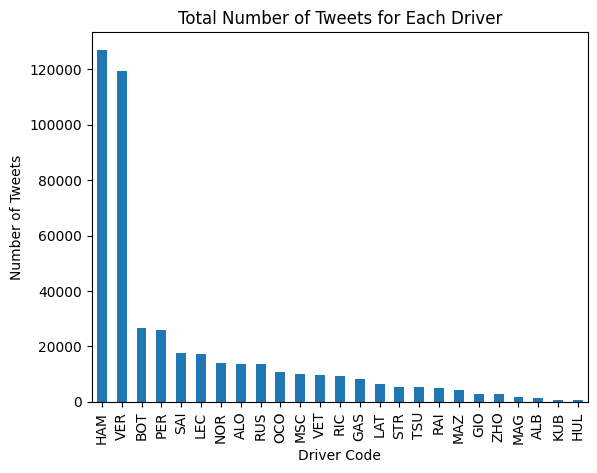

In [ ]:
# bar chart of number of tweets per driver
tweet_race_data["code"].value_counts().plot(kind="bar")
plt.title("Total Number of Tweets for Each Driver")
plt.xlabel("Driver Code")
plt.ylabel("Number of Tweets")

It is easy with this graph to see how popular Lewis Hamilton and Max Verstappen are in the media compared to the other drivers. This is most likely due to the large controversy in 2021 between the two drivers, when Verstappen won the championship, in a season with five changes of leadership in 22 rounds. This major upset occurred after the 2021 Abu Dhabi Grand Prix. 

Text(142.34722222222223, 0.5, 'Raw Compound Sentiment Score')

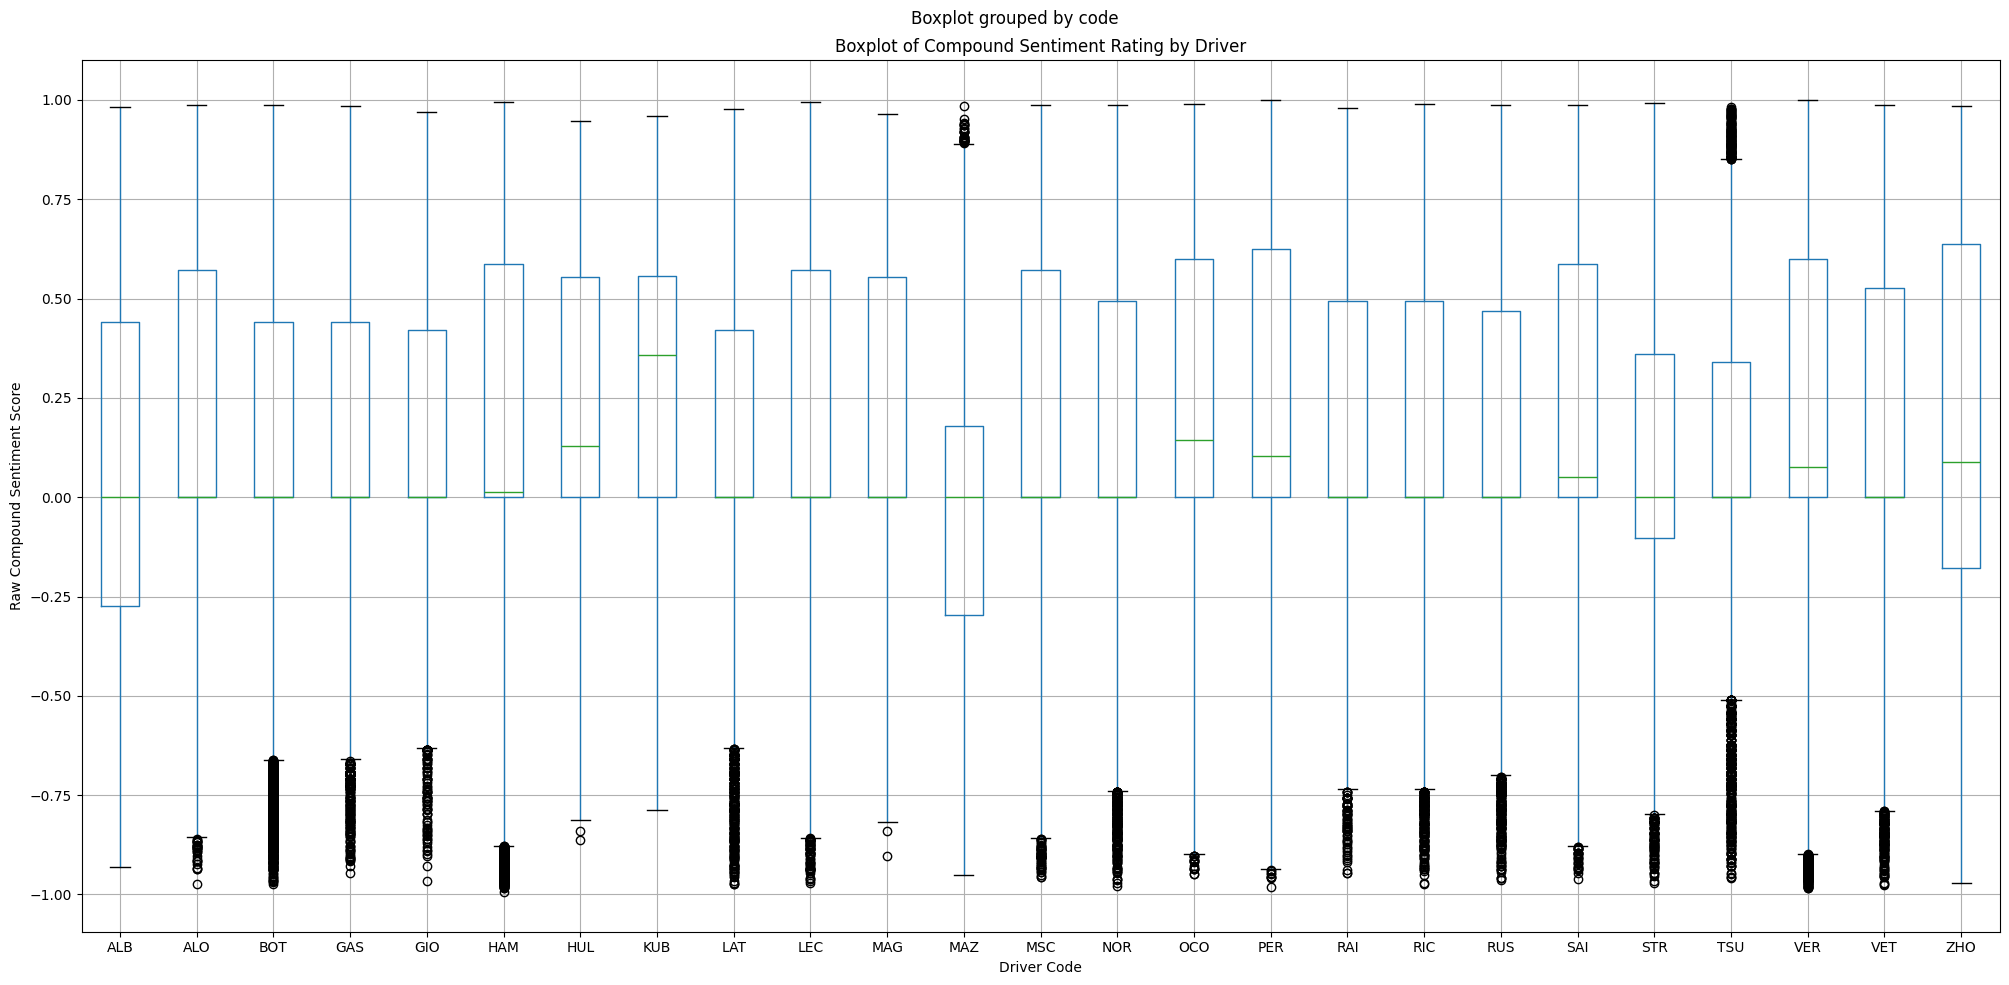

In [ ]:
# box plot of sentiment ratings for each driver
tweet_race_data.boxplot(
    column=["compound_sentiment_rating"], by="code", figsize=(20, 10)
)
plt.tight_layout()
plt.title("Boxplot of Compound Sentiment Rating by Driver")
plt.xlabel("Driver Code")
plt.ylabel("Raw Compound Sentiment Score")

This plot helps to see what each distribution looks like for each driver in comparison to one another. It is also helpful to see the outliers. 

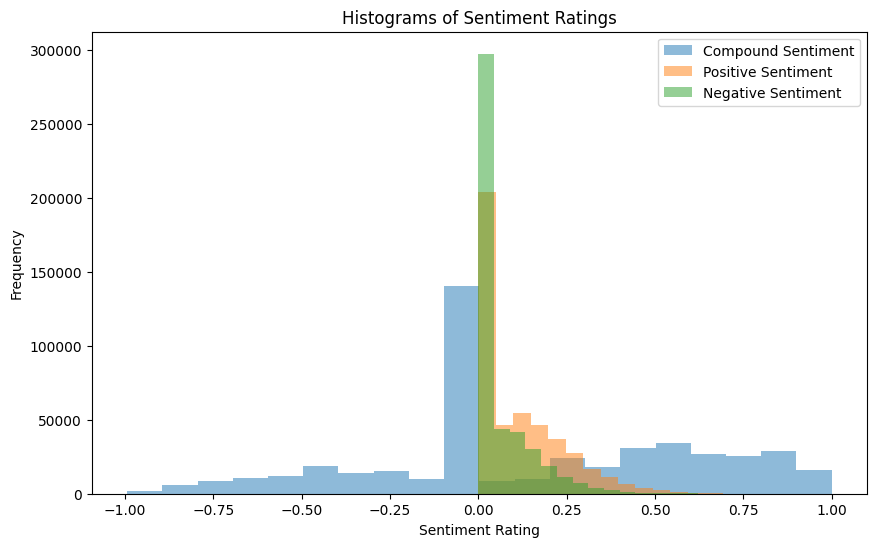

In [ ]:
# Distribution of Sentiment Ratings
plt.figure(figsize=(10, 6))
plt.hist(
    tweet_race_data["compound_sentiment_rating"],
    bins=20,
    alpha=0.5,
    label="Compound Sentiment",
)
plt.hist(
    tweet_race_data["pos_sentiment_rating"],
    bins=20,
    alpha=0.5,
    label="Positive Sentiment",
)
plt.hist(
    tweet_race_data["neg_sentiment_rating"],
    bins=20,
    alpha=0.5,
    label="Negative Sentiment",
)
plt.xlabel("Sentiment Rating")
plt.ylabel("Frequency")
plt.title("Histograms of Sentiment Ratings")
plt.legend()
plt.show()

Here are the distributions for all tweet sentiment scores. We can see overall there are more negative than positive, but the positive sentiments are more frequently greater(closer to value of 1). This means when public opinion is positive, it is more strongly expressed then when it is negative, but there is a greater total number of negative tweets. 

### Calculate aggregate sentiment scores for each race and driver 

In [ ]:
tweet_race_data.head()

,raceId,name,date_race,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,finished,wonPoints,crashed,carIssues,user_followers,date_tweet,text,compound_sentiment_rating,pos_sentiment_rating,neg_sentiment_rating
131,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,5352.0,2021-12-12 15:38:03,niche tweet \n\nthe fia is to lewis \n\nwhat a...,0.0000,0.000,0.000
132,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,961.0,2021-12-12 15:00:23,alexandercevans digitalwilson then tell toto...,0.5859,0.155,0.058
133,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,240.0,2021-12-12 14:39:20,alexanderdack like hamilton in the best car b...,0.9325,0.322,0.055
140,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,4228.0,2021-12-16 04:56:15,cool to see manor drivers will stevens amp a...,0.3182,0.108,0.000
141,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,25.0,2021-12-13 21:35:43,alexander amp arthur were ready for the last...,0.8779,0.194,0.000


In [ ]:
# Extracts tweets only from before the race weekend
tweet_race_data["date_tweet"] = pd.to_datetime(tweet_race_data["date_tweet"])
tweet_race_data["date_race"] = pd.to_datetime(tweet_race_data["date_race"])
tweet_race_data = tweet_race_data[
    tweet_race_data["date_tweet"]
    < tweet_race_data["date_race"] - pd.to_timedelta(2, unit="d")
]
tweet_race_data.head()

,raceId,name,date_race,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,finished,wonPoints,crashed,carIssues,user_followers,date_tweet,text,compound_sentiment_rating,pos_sentiment_rating,neg_sentiment_rating
131,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,5352.0,2021-12-12 15:38:03,niche tweet \n\nthe fia is to lewis \n\nwhat a...,0.0000,0.000,0.000
132,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,961.0,2021-12-12 15:00:23,alexandercevans digitalwilson then tell toto...,0.5859,0.155,0.058
133,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,240.0,2021-12-12 14:39:20,alexanderdack like hamilton in the best car b...,0.9325,0.322,0.055
140,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,4228.0,2021-12-16 04:56:15,cool to see manor drivers will stevens amp a...,0.3182,0.108,0.000
141,1074,Bahrain Grand Prix,2022-03-20 15:00:00,15:00:00,848,albon,ALB,3,williams,14,...,1,0,0,0,25.0,2021-12-13 21:35:43,alexander amp arthur were ready for the last...,0.8779,0.194,0.000


In [ ]:
tweet_race_data["user_followers"] = tweet_race_data.user_followers.astype(float)

In [ ]:
# calculates the weighted average compound sentiment scores weighted by the twitter user's follower count
agg_df = (
    tweet_race_data.groupby(["raceId", "driverRef"])
    .apply(
        lambda group: (
            sum(group["user_followers"] * group["compound_sentiment_rating"])
        )
        / sum(group["user_followers"])
    )
    .reset_index(name="weighted_avg_compound_sentiment")
)

In [ ]:
agg_df.head()

,raceId,driverRef,weighted_avg_compound_sentiment
0,1051,alonso,0.217954
1,1051,bottas,0.334296
2,1051,gasly,0.054057
3,1051,giovinazzi,0.152834
4,1051,hamilton,0.213152


Calculate the number of tweets

In [ ]:
agg_df["pos_tweets_sum"] = (
    tweet_race_data.groupby(["raceId", "driverRef"])
    .apply(lambda group: sum(group["compound_sentiment_rating"] > 0.05))
    .reset_index(name="pos_tweets_sum")["pos_tweets_sum"]
)
agg_df["neg_tweets_sum"] = (
    tweet_race_data.groupby(["raceId", "driverRef"])
    .apply(lambda group: sum(group["compound_sentiment_rating"] < -0.05))
    .reset_index(name="neg_tweets_sum")["neg_tweets_sum"]
)
agg_df.head()

,raceId,driverRef,weighted_avg_compound_sentiment,pos_tweets_sum,neg_tweets_sum
0,1051,alonso,0.217954,115,68
1,1051,bottas,0.334296,712,294
2,1051,gasly,0.054057,163,56
3,1051,giovinazzi,0.152834,148,118
4,1051,hamilton,0.213152,6095,2302


In [ ]:
agg_df["total_tweets"] = (
    (tweet_race_data.groupby(["raceId", "driverRef"]).size()).reset_index().iloc[:, 2]
)
agg_df["avg_compound_sentiment"] = (
    tweet_race_data.groupby(["raceId", "driverRef"])
    .apply(lambda group: group["compound_sentiment_rating"].mean())
    .reset_index(name="avg_compound_sentiment")["avg_compound_sentiment"]
)

Calculate percentage of positive and negative tweets

In [ ]:
agg_df["pos_tweets_perc"] = agg_df["pos_tweets_sum"] * 100 / agg_df["total_tweets"]
agg_df["neg_tweets_perc"] = agg_df["neg_tweets_sum"] * 100 / agg_df["total_tweets"]
agg_df["neut_tweets_perc"] = 100 - agg_df["pos_tweets_perc"] - agg_df["neg_tweets_perc"]
agg_df["pos_tweets_ratio"] = agg_df["pos_tweets_sum"] / (agg_df["neg_tweets_sum"])
agg_df["neg_tweets_ratio"] = agg_df["neg_tweets_sum"] / (agg_df["pos_tweets_sum"])
agg_df["sentiment"] = pd.cut(
    agg_df["avg_compound_sentiment"],
    bins=[-1, -0.05, 0.05, 1],
    labels=["negative", "neutral", "positive"],
)
agg_df.head()

,raceId,driverRef,weighted_avg_compound_sentiment,pos_tweets_sum,neg_tweets_sum,total_tweets,avg_compound_sentiment,pos_tweets_perc,neg_tweets_perc,neut_tweets_perc,pos_tweets_ratio,neg_tweets_ratio,sentiment
0,1051,alonso,0.217954,115,68,270,0.130062,42.592593,25.185185,32.222222,1.691176,0.591304,positive
1,1051,bottas,0.334296,712,294,1592,0.166931,44.723618,18.467337,36.809045,2.421769,0.412921,positive
2,1051,gasly,0.054057,163,56,427,0.135354,38.173302,13.114754,48.711944,2.910714,0.343558,positive
3,1051,giovinazzi,0.152834,148,118,432,0.110256,34.259259,27.314815,38.425926,1.254237,0.797297,positive
4,1051,hamilton,0.213152,6095,2302,12421,0.202564,49.070123,18.533129,32.396747,2.647698,0.377687,positive


In [ ]:
grouped_df = agg_df.groupby(["driverRef", "sentiment"]).size().reset_index(name="count")
grouped_df.head()

,driverRef,sentiment,count
0,albon,negative,1
1,albon,neutral,0
2,albon,positive,4
3,alonso,negative,0
4,alonso,neutral,0


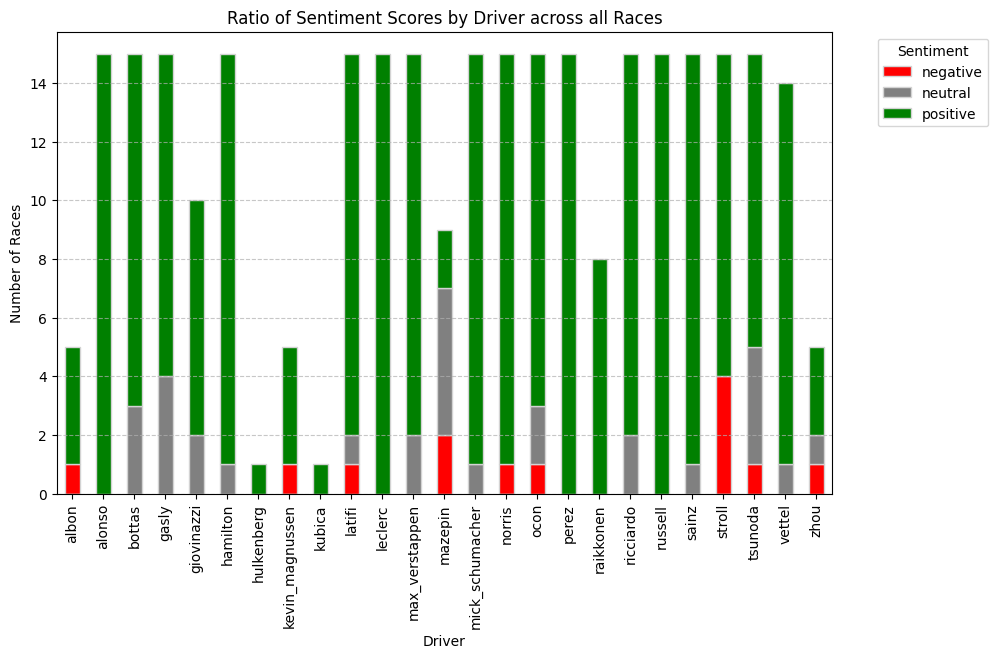

In [ ]:
pivot_df = grouped_df.pivot(
    index="driverRef", columns="sentiment", values="count"
).fillna(0)

colors = {"positive": "green", "negative": "red", "neutral": "grey"}

ax = pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=[colors[col] for col in pivot_df.columns],
    edgecolor="lightgrey",
)


ax.set_title("Ratio of Sentiment Scores by Driver across all Races")

ax.set_xlabel("Driver")

ax.set_ylabel("Number of Races")

ax.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left")


ax.grid(True, linestyle="--", alpha=0.7, which="both", axis="y", zorder=-2)

The tweets before each race are grouped and given an averaged positive, neutral, or negative score. This visualization shows the proportions of these sentiment categories across all races. The drivers who did not compete in every race, such as Albon for example, or who did not have any tweets for a specific race will have lower bars. The categories were given a 0.05 threshold between neutral and the other groups which is why some drivers. 

In [ ]:
tweet_race_data.columns

Index(['raceId', 'name', 'date_race', 'time_x', 'driverId', 'driverRef',
       'code', 'constructorId', 'constructorRef', 'grid', 'position',
       'positionOrder', 'points', 'time_y', 'milliseconds', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'status', 'year', 'prev_date',
       'prev_time', 'quali_date', 'relative_position',
       'relative_fastestLapSpeed', 'positionGain', 'prev_position',
       'fastestSpeedGain', 'positionChange', 'finished', 'wonPoints',
       'crashed', 'carIssues', 'user_followers', 'date_tweet', 'text',
       'compound_sentiment_rating', 'pos_sentiment_rating',
       'neg_sentiment_rating'],
      dtype='object')

# Correlation Analysis

In [ ]:
final_data = pd.merge(race_data, agg_df, on=["raceId", "driverRef"], how="left")
final_data.head()

,raceId,name,date,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,pos_tweets_sum,neg_tweets_sum,total_tweets,avg_compound_sentiment,pos_tweets_perc,neg_tweets_perc,neut_tweets_perc,pos_tweets_ratio,neg_tweets_ratio,sentiment
0,1074,Bahrain Grand Prix,2022-03-20,15:00:00,848,albon,ALB,3,williams,14,...,203.0,55.0,386.0,0.215752,52.590674,14.248705,33.160622,3.690909,0.270936,positive
1,1075,Saudi Arabian Grand Prix,2022-03-27,17:00:00,848,albon,ALB,3,williams,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1076,Australian Grand Prix,2022-04-10,05:00:00,848,albon,ALB,3,williams,20,...,30.0,99.0,163.0,-0.206908,18.404908,60.736196,20.858896,0.303030,3.300000,negative
3,1077,Emilia Romagna Grand Prix,2022-04-24,13:00:00,848,albon,ALB,3,williams,18,...,12.0,6.0,32.0,0.123006,37.500000,18.750000,43.750000,2.000000,0.500000,positive
4,1078,Miami Grand Prix,2022-05-08,19:30:00,848,albon,ALB,3,williams,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# final_data.info()

<Axes: xlabel='avg_compound_sentiment', ylabel='prev_position'>

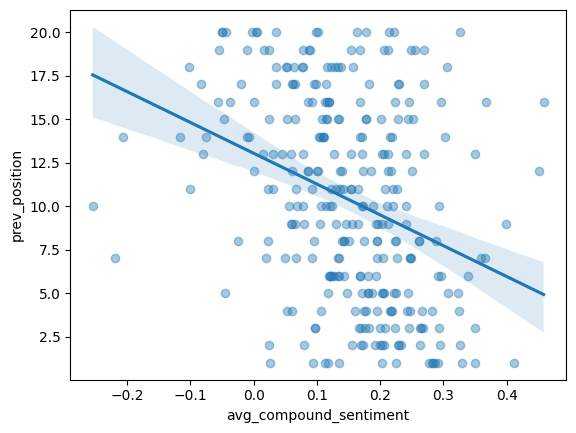

In [ ]:
sns.regplot(
    data=final_data,
    x="avg_compound_sentiment",
    y="prev_position",
    scatter_kws={"alpha": 0.4},
)

In [ ]:
final_data.to_csv("data/complete_data.csv", index=False)

This shows that the higher the driver was ranked in the previous race, the more positive the tweets related to the driver. As this is an expected result, it means our data is likely to be correct.

### Calculate correlation of sentiments with driver race performance indicators

In [ ]:
# Correlation by Specific Driver


# Creates a subset of data matching only one driver
def subset_by_driver(name):
    return final_data[final_data["code"] == name]


# Drops unnecessary columns and plots a correlation heatmap
def corr_map_driver(name):
    corr_df = subset_by_driver(name)
    corr_df = corr_df.select_dtypes(include=["number"])
    corr_df = corr_df.drop(
        [
            "raceId",
            "driverId",
            "constructorId",
            "pos_tweets_perc",
            "neg_tweets_perc",
            "neut_tweets_perc",
            "pos_tweets_ratio",
            "neg_tweets_ratio",
            "carIssues",
        ],
        axis=1,
    )
    corr_df = corr_df.corr()
    plt.figure(figsize=(14, 11))
    sns.set(font_scale=1.2)
    sns.heatmap(
        corr_df,
        annot=True,
        cmap="viridis",
        fmt=".1f",
        linewidths=0.5,
        mask=np.triu(np.ones_like(corr_df.corr(), dtype=bool)),
    )
    plt.title("Correlation Heatmap for " + name)
    plt.show()

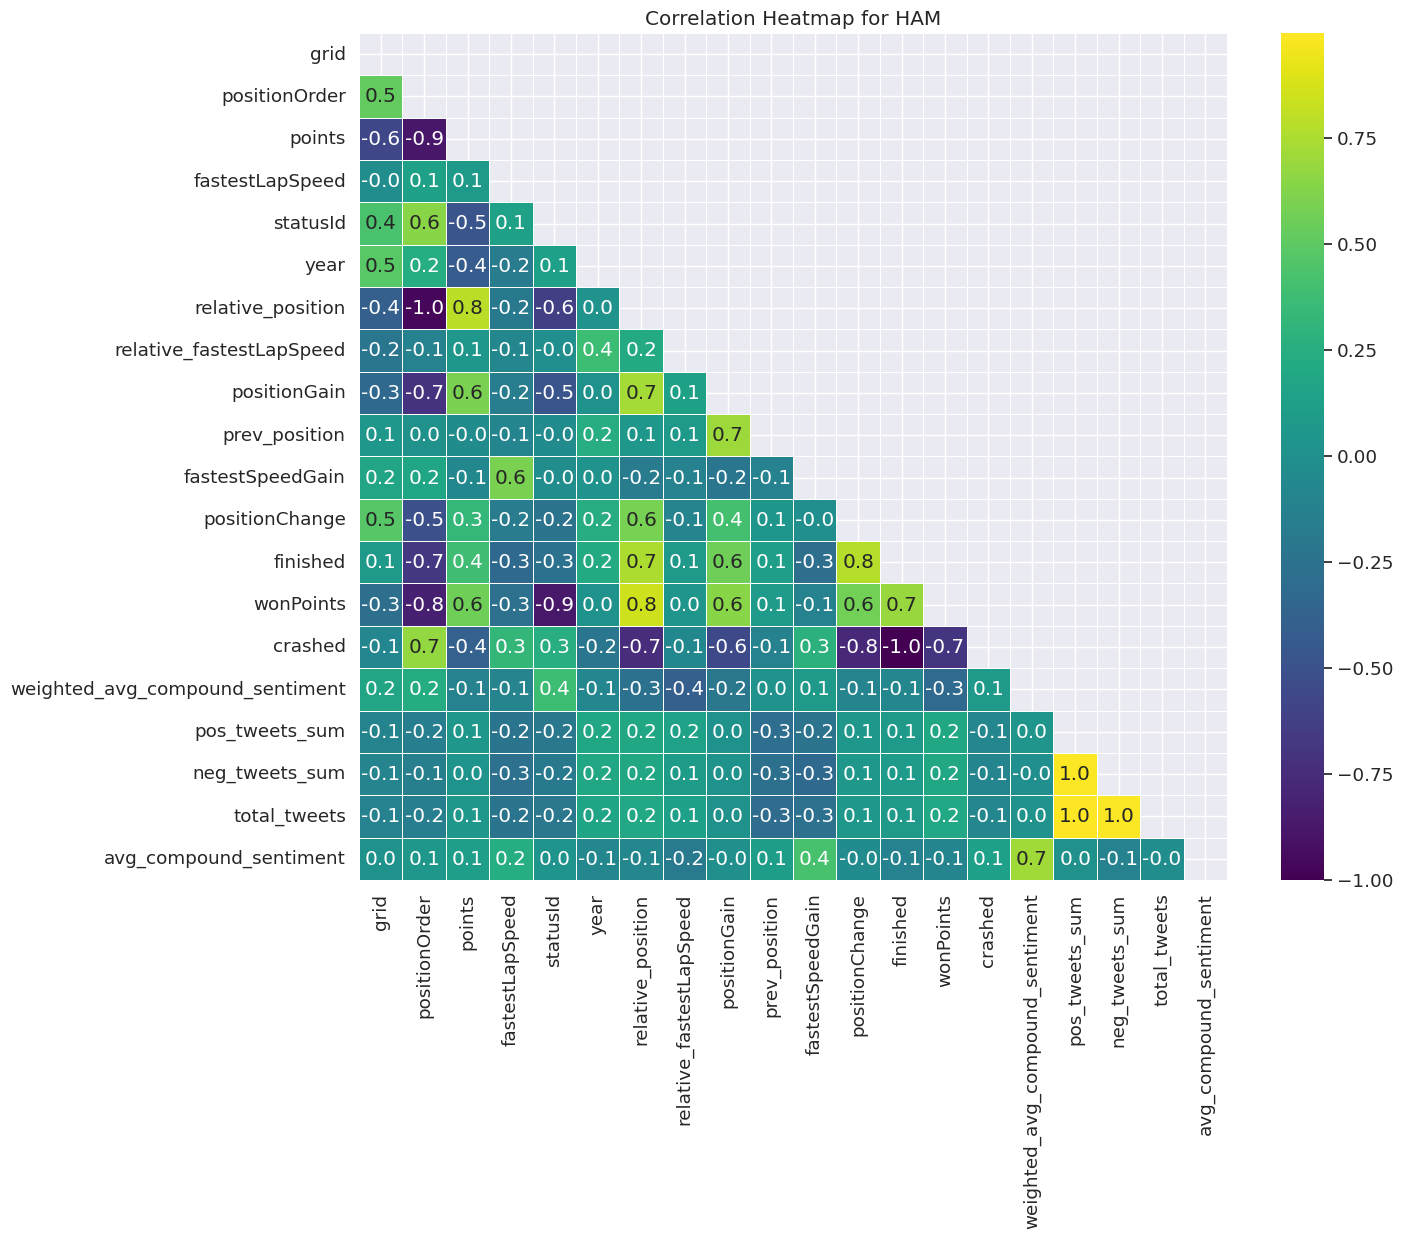

In [ ]:
# Example Driver: Hamilton
corr_map_driver("HAM")

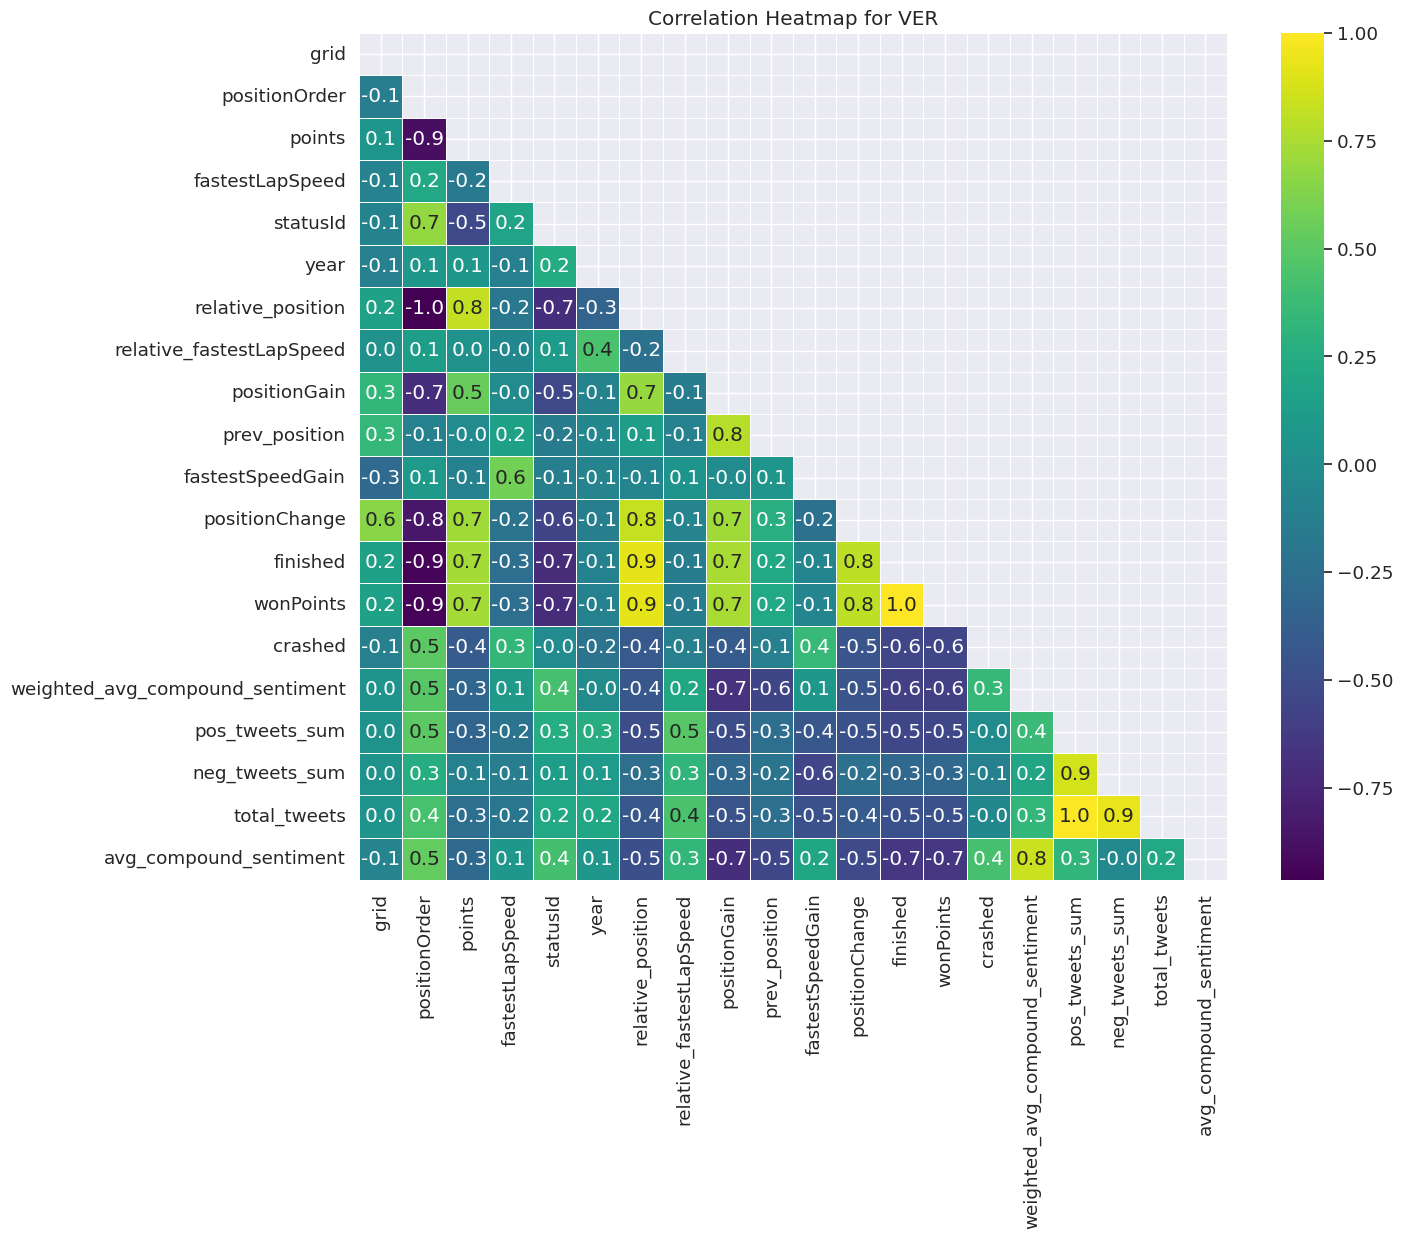

In [ ]:
# Example Driver: Verstappen

corr_map_driver("VER")

In [ ]:
# Correlation overall
corr = final_data.iloc[:, [9, 11, 14, 16] + list(range(23, 43))].corr()
corr.head()

,grid,positionOrder,fastestLapSpeed,relative_position,relative_fastestLapSpeed,positionGain,prev_position,fastestSpeedGain,positionChange,finished,...,weighted_avg_compound_sentiment,pos_tweets_sum,neg_tweets_sum,total_tweets,avg_compound_sentiment,pos_tweets_perc,neg_tweets_perc,neut_tweets_perc,pos_tweets_ratio,neg_tweets_ratio
grid,1.000000,0.498438,-0.094965,-0.309258,0.028864,-0.044376,0.448198,-0.021210,0.513651,-0.162145,...,-0.079153,-0.232302,-0.220197,-0.241898,-0.277370,-0.306108,0.183888,0.179554,-0.199693,0.236337
positionOrder,0.498438,1.000000,-0.125582,-0.799488,0.060503,-0.557811,0.379011,-0.042980,-0.487797,-0.674976,...,0.016054,-0.111546,-0.164207,-0.144251,-0.061694,-0.106024,-0.026630,0.159939,-0.037522,0.042789
fastestLapSpeed,-0.094965,-0.125582,1.000000,0.080647,-0.103052,0.055101,-0.062579,0.607241,0.028124,0.064201,...,-0.063035,-0.013549,-0.009647,-0.003669,-0.061800,-0.113677,0.058152,0.077692,0.009976,0.063743
relative_position,-0.309258,-0.799488,0.080647,1.000000,-0.104453,0.524385,-0.201065,0.031947,0.476820,0.564775,...,-0.028109,0.061856,0.121417,0.089925,-0.040562,0.009574,0.098926,-0.119063,-0.069185,0.023235
relative_fastestLapSpeed,0.028864,0.060503,-0.103052,-0.104453,1.000000,-0.026714,0.024514,-0.005690,-0.031059,-0.057520,...,0.106256,0.097697,0.058168,0.082441,0.093001,0.074529,-0.018796,-0.071714,0.070740,-0.039724


In [ ]:
corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, grid to neg_tweets_ratio
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   grid                             23 non-null     float64
 1   positionOrder                    23 non-null     float64
 2   fastestLapSpeed                  23 non-null     float64
 3   relative_position                23 non-null     float64
 4   relative_fastestLapSpeed         23 non-null     float64
 5   positionGain                     23 non-null     float64
 6   prev_position                    23 non-null     float64
 7   fastestSpeedGain                 23 non-null     float64
 8   positionChange                   23 non-null     float64
 9   finished                         23 non-null     float64
 10  wonPoints                        23 non-null     float64
 11  crashed                          23 non-null     float64
 12  carIssues   

In [ ]:
# dropping duplicates
corr.drop(
    corr.columns[13:],
    axis=1,
    inplace=True,
)
corr.drop(
    corr.index[:13],
    axis=0,
    inplace=True,
)
corr.drop(corr.columns[6], axis=1, inplace=True)  # dropping prev_position
corr

,grid,positionOrder,fastestLapSpeed,relative_position,relative_fastestLapSpeed,positionGain,fastestSpeedGain,positionChange,finished,wonPoints,crashed,carIssues
weighted_avg_compound_sentiment,-0.079153,0.016054,-0.063035,-0.028109,0.106256,-0.176961,-0.042234,-0.094110,-0.067873,-0.033490,0.003725,0.078464
pos_tweets_sum,-0.232302,-0.111546,-0.013549,0.061856,0.097697,-0.157714,-0.081742,-0.121626,-0.023250,0.077713,-0.040557,0.060207
neg_tweets_sum,-0.220197,-0.164207,-0.009647,0.121417,0.058168,-0.072432,-0.106613,-0.058321,0.029042,0.110490,-0.054244,0.008374
total_tweets,-0.241898,-0.144251,-0.003669,0.089925,0.082441,-0.131225,-0.083549,-0.099277,-0.000886,0.100023,-0.047868,0.039200
avg_compound_sentiment,-0.277370,-0.061694,-0.061800,-0.040562,0.093001,-0.240839,-0.054683,-0.214873,-0.102420,0.056114,0.085728,0.054579
pos_tweets_perc,-0.306108,-0.106024,-0.113677,0.009574,0.074529,-0.190706,-0.119986,-0.200175,-0.073266,0.071032,0.041416,0.054905
neg_tweets_perc,0.183888,-0.026630,0.058152,0.098926,-0.018796,0.206383,-0.045581,0.208245,0.191853,0.010570,-0.126111,-0.129704
neut_tweets_perc,0.179554,0.159939,0.077692,-0.119063,-0.071714,0.012492,0.189877,0.022187,-0.117022,-0.099284,0.085263,0.072469
pos_tweets_ratio,-0.199693,-0.037522,0.009976,-0.069185,0.070740,-0.200116,0.061535,-0.161366,-0.088339,0.035674,0.103890,0.021180
neg_tweets_ratio,0.236337,0.042789,0.063743,0.023235,-0.039724,0.183681,0.069052,0.192611,0.116519,-0.023895,-0.107288,-0.054318


<Axes: >

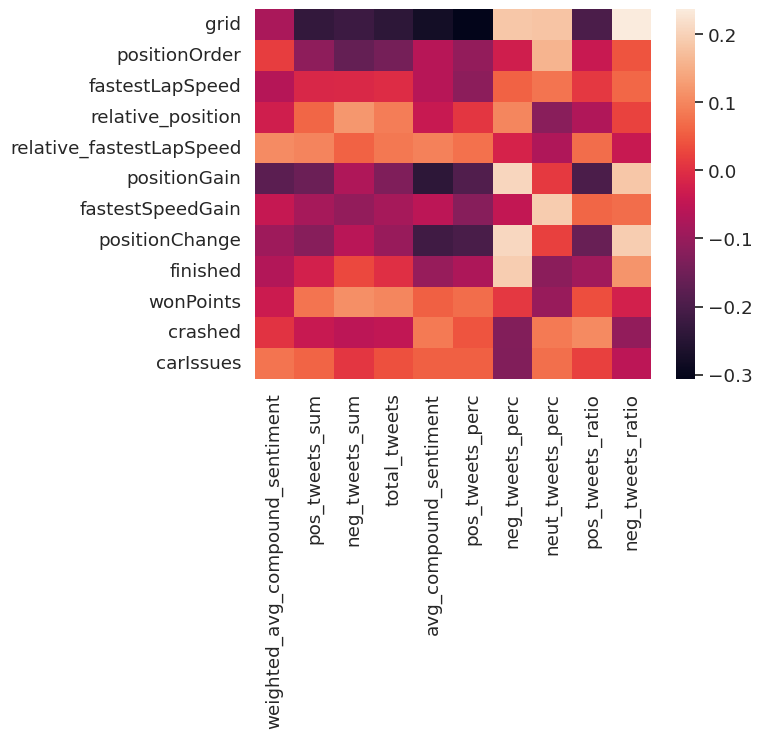

In [ ]:
sns.heatmap(corr.T, annot=False)

Finding features with highest correlation

In [ ]:
top_corr = corr.unstack().sort_values(ascending=False, key=abs)
top_corr = pd.DataFrame(top_corr).reset_index()
top_corr.columns = ["feature_1", "feature_2", "correlation"]
top_corr.head(10)

,feature_1,feature_2,correlation
0,grid,pos_tweets_perc,-0.306108
1,grid,avg_compound_sentiment,-0.277370
2,grid,total_tweets,-0.241898
3,positionGain,avg_compound_sentiment,-0.240839
4,grid,neg_tweets_ratio,0.236337
5,grid,pos_tweets_sum,-0.232302
6,grid,neg_tweets_sum,-0.220197
7,positionChange,avg_compound_sentiment,-0.214873
8,positionChange,neg_tweets_perc,0.208245
9,positionGain,neg_tweets_perc,0.206383


This shows that the qualifying results are most affected by public sentiment on social media, followed by the drivers' change in performance from one race to the next. It also shows that positive tweets have a larger effect than negative ones.

### Analyze effect of sentiments on race stats

<Axes: xlabel='avg_compound_sentiment', ylabel='positionGain'>

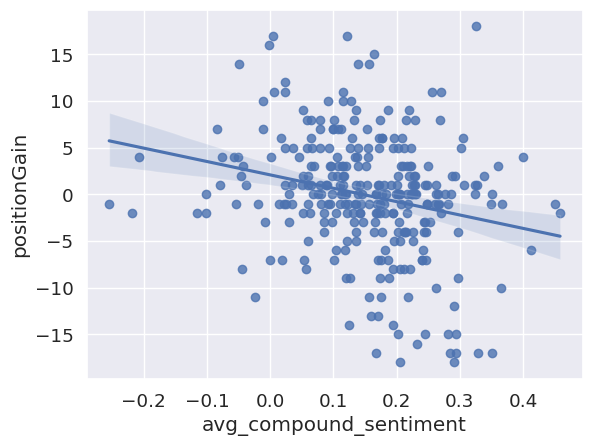

In [ ]:
sns.regplot(
    data=final_data, x="avg_compound_sentiment", y="positionGain"
)  # position gain is the difference between current race finish position and prev race finish position

This shows that the more positive the tweets about a driver, the more his performance decreases from the previous race. To explain this result, we shall investigate further.

<Axes: xlabel='avg_compound_sentiment', ylabel='grid'>

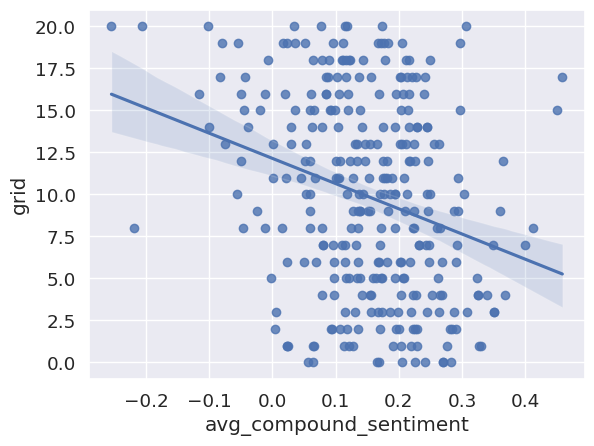

In [ ]:
sns.regplot(data=final_data, x="avg_compound_sentiment", y="grid")

This shows us that the more positive the tweets on a driver before an upcoming race, the better they perform during the qualifying session. This determines their starting position on the grid the next day during the race. 

<Axes: xlabel='avg_compound_sentiment', ylabel='positionChange'>

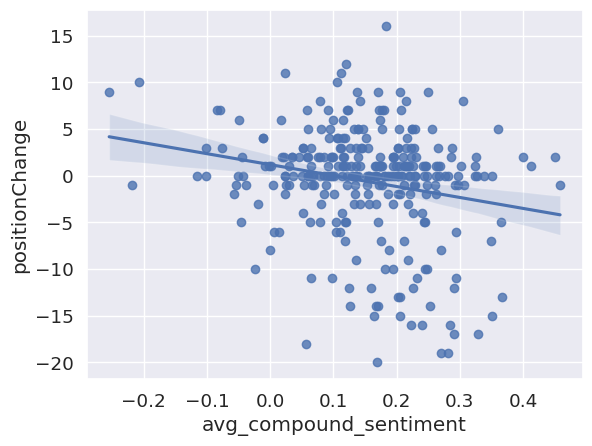

In [ ]:
sns.regplot(data=final_data, x="avg_compound_sentiment", y="positionChange")

<Axes: xlabel='grid', ylabel='positionChange'>

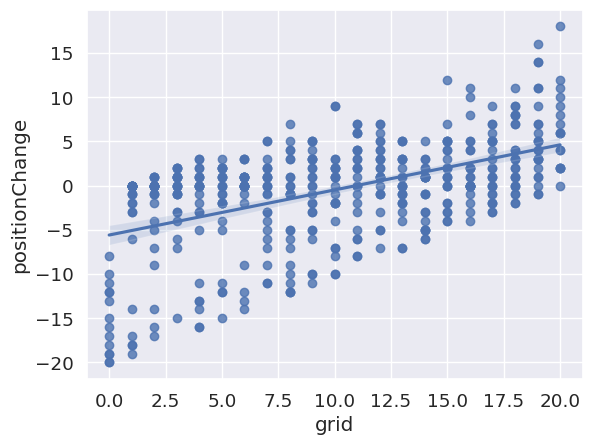

In [ ]:
sns.regplot(data=final_data, x="grid", y="positionChange")

The first plot indicates that the more positive the sentiment, the worse they perform during the race. This is explained by the second plot, where we can see that the better the position on the starting grid, the worse they perform. Two possible scenarios that can explain this - either a driver becomes overconfident when they do well in qualifying, or they buckle under the tremendous pressure to keep up their performance. It also shows us that when a driver starts at the back of the grid, they perform better during the race and finish at a better position, possibly due to pressure and determination to improve their performance. 

<Axes: xlabel='positionChange', ylabel='positionOrder'>

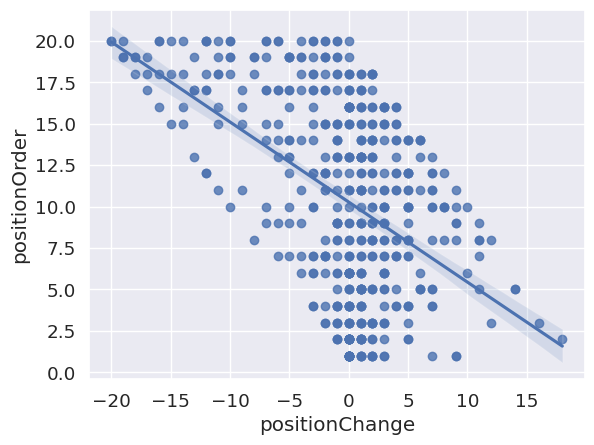

In [ ]:
sns.regplot(data=final_data, x="positionChange", y="positionOrder")

<Axes: xlabel='positionOrder', ylabel='positionGain'>

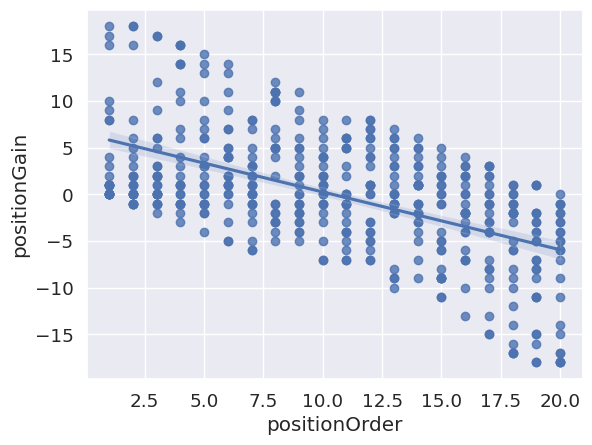

In [ ]:
sns.regplot(data=final_data, x="positionOrder", y="positionGain")

The figures above show that the more the drivers decrease performance during the race, the worse their results, and the more the likelihood of the drivers performing worse than they did last race. Which brings us back to the initial result that the more positive the sentiment, the more the driver's performance decreases the next race, and vice versa. 

<Axes: xlabel='pos_tweets_perc', ylabel='positionGain'>

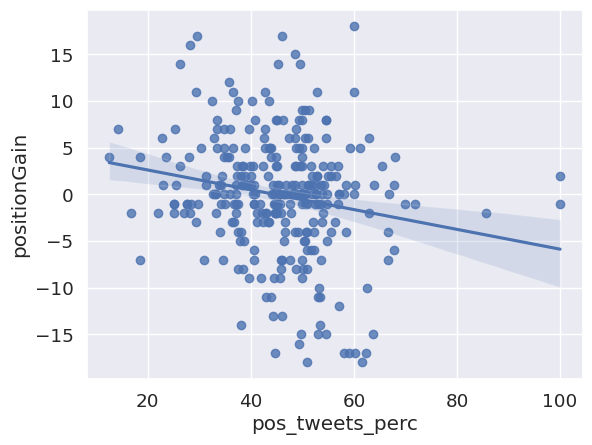

In [ ]:
sns.regplot(data=final_data, x="pos_tweets_perc", y="positionGain")

<Axes: xlabel='neg_tweets_perc', ylabel='positionGain'>

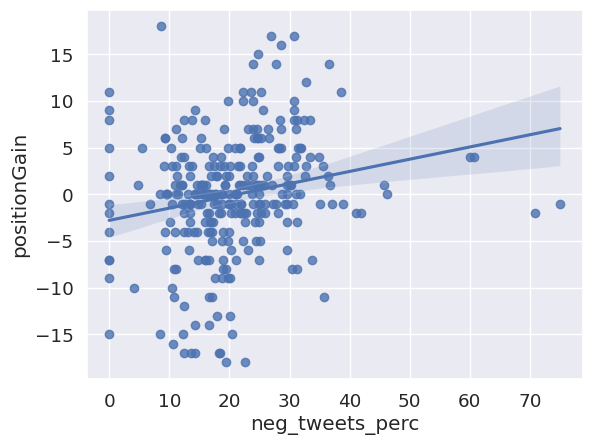

In [ ]:
sns.regplot(data=final_data, x="neg_tweets_perc", y="positionGain")

## Classification of Improvement vs. no Improvment

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Libraries
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
import statistics as stat
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay, confusion_matrix

In [ ]:
# Create the improved column,
# which indicates whether a driver acheived a better finishing position than last race
final_data["improved"] = np.where(
    final_data.positionOrder < final_data.prev_position, 1, 0
)

In [ ]:
final_data.improved.value_counts()

0    275
1    225
Name: improved, dtype: int64

In [ ]:
final_data[final_data.improved == 1].head()

,raceId,name,date,time_x,driverId,driverRef,code,constructorId,constructorRef,grid,...,neg_tweets_sum,total_tweets,avg_compound_sentiment,pos_tweets_perc,neg_tweets_perc,neut_tweets_perc,pos_tweets_ratio,neg_tweets_ratio,sentiment,improved
2,1076,Australian Grand Prix,2022-04-10,05:00:00,848,albon,ALB,3,williams,20,...,99.0,163.0,-0.206908,18.404908,60.736196,20.858896,0.303030,3.300000,negative,1
4,1078,Miami Grand Prix,2022-05-08,19:30:00,848,albon,ALB,3,williams,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,1081,Azerbaijan Grand Prix,2022-06-12,11:00:00,848,albon,ALB,3,williams,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
10,1084,Austrian Grand Prix,2022-07-10,13:00:00,848,albon,ALB,3,williams,15,...,103.0,363.0,0.214423,54.545455,28.374656,17.079890,1.922330,0.520202,positive,1
13,1062,Hungarian Grand Prix,2021-08-01,13:00:00,4,alonso,ALO,214,alpine,9,...,31.0,298.0,0.359814,65.436242,10.402685,24.161074,6.290323,0.158974,positive,1


In [ ]:
final_data.columns

Index(['raceId', 'name', 'date', 'time_x', 'driverId', 'driverRef', 'code',
       'constructorId', 'constructorRef', 'grid', 'position', 'positionOrder',
       'points', 'time_y', 'milliseconds', 'fastestLapTime', 'fastestLapSpeed',
       'statusId', 'status', 'year', 'prev_date', 'prev_time', 'quali_date',
       'relative_position', 'relative_fastestLapSpeed', 'positionGain',
       'prev_position', 'fastestSpeedGain', 'positionChange', 'finished',
       'wonPoints', 'crashed', 'carIssues', 'weighted_avg_compound_sentiment',
       'pos_tweets_sum', 'neg_tweets_sum', 'total_tweets',
       'avg_compound_sentiment', 'pos_tweets_perc', 'neg_tweets_perc',
       'neut_tweets_perc', 'pos_tweets_ratio', 'neg_tweets_ratio', 'sentiment',
       'improved'],
      dtype='object')

In [ ]:
# Create a new dataframe that contains only the target label,
# and the features we want to use for prediction
ml_data = final_data[
    [
        "avg_compound_sentiment",
        "pos_tweets_sum",
        "neg_tweets_sum",
        "prev_position",
        "improved",
    ]
]
# fill missing tweet data, and drop the rows when the driver didn't previouly race
ml_data.fillna(0, inplace=True)
ml_data = ml_data[ml_data.prev_position > 0]
# Construct our X and y dataframes and split them into train and test data
X = ml_data[
    ["avg_compound_sentiment", "pos_tweets_sum", "neg_tweets_sum", "prev_position"]
]
y = ml_data["improved"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# construct a pipeline that scales data, performs feature expansion, and then logistic regression
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=1)),
        (
            "mod",
            LogisticRegression(
                random_state=42,
                solver="liblinear",
                max_iter=1000,
                class_weight="balanced",
            ),
        ),
    ]
)
# perform grid search across a parameter grid to fine tune the model
gridcv = GridSearchCV(
    pipe,
    param_grid={
        "mod__C": [0.1, 1, 10, 100],
        "mod__penalty": ["l1", "l2"],
        "poly__degree": [1, 2, 3],
        "scaler": [StandardScaler()],
    },
    return_train_score=True,
    cv=10,
    n_jobs=2,
)
# fit the grid search model, ouput test accuracy, and best parameters
gridcv.fit(X_train, y_train)
print(f"Logistic Regression: {gridcv.score(X_test, y_test)}")
print(gridcv.best_params_)

Logistic Regression: 0.7373737373737373
{'mod__C': 0.1, 'mod__penalty': 'l2', 'poly__degree': 3, 'scaler': StandardScaler()}
/shared-libs/python3.11/py/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


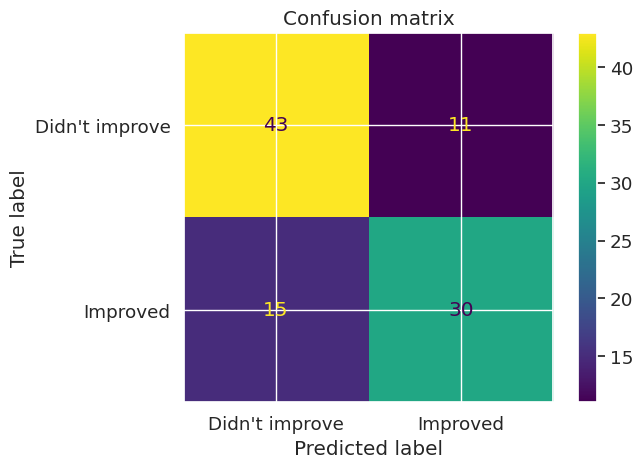

In [ ]:
# create a confusion matrix display for final model
y_pred = gridcv.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["Didn't improve", "Improved"])
disp.plot(values_format=".0f")
plt.title("Confusion matrix")
plt.savefig("confusion_matrix.pdf")
plt.show()

The confusion matrix shows that most predictions fall on the diagonal line where our predicted label and true label are the same, meaning that we have predominantly correct predictions. We have 73 correct predictions, compared to 26 incorrect predictions. We think that this figure shows that our model is performing well.


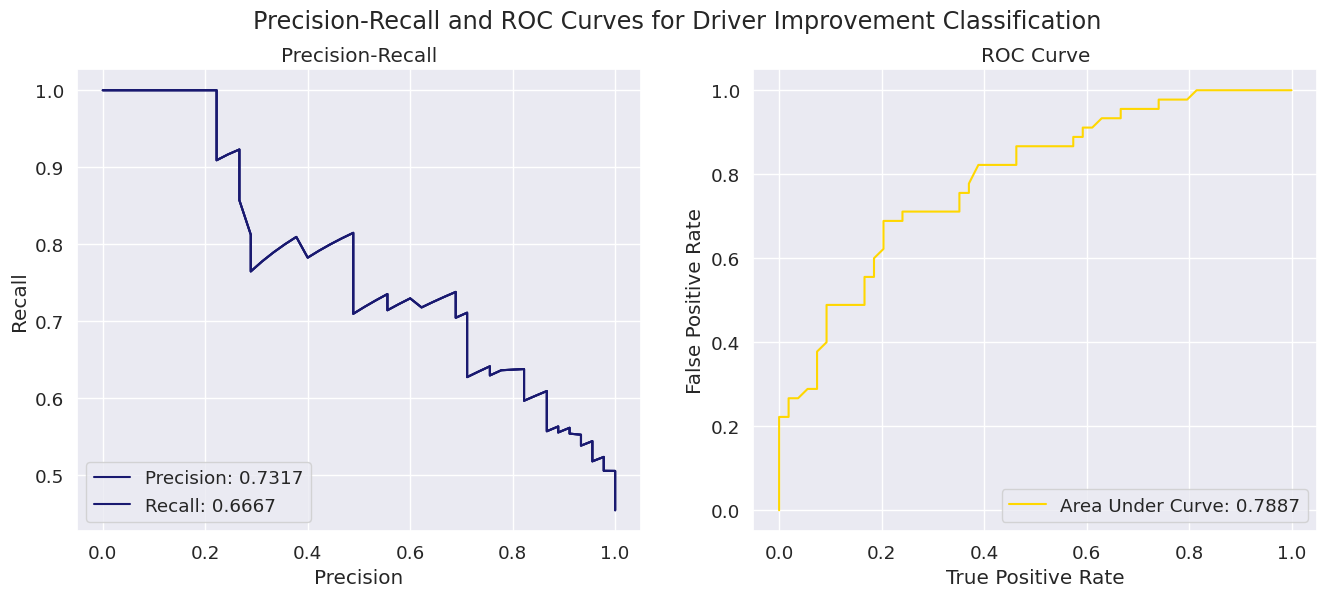

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# create the precision recall curves
fig.suptitle("Precision-Recall and ROC Curves for Driver Improvement Classification")
fig.subplots_adjust(hspace=0.5, wspace=0.2)
axs = axs.ravel()
colors = ["midnightblue", "gold"]


classifier = gridcv


y_pred = classifier.predict(X_test)

# calculate the true precision and recall scores, and then the curve
prec_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
y_pred = classifier.predict_proba(X_test)[:, 1]
precision, recall, threshholds = precision_recall_curve(y_test, y_pred)

# plot precision recall curve
axs[0].plot(
    recall, precision, color="midnightblue", label=f"Precision: {prec_score.round(4)}"
)
axs[0].plot(
    recall, precision, color="midnightblue", label=f"Recall: {rec_score.round(4)}"
)
axs[0].plot(recall, precision, color="midnightblue")
axs[0].set_title(f"Precision-Recall")
axs[0].set_ylabel("Recall")
axs[0].set_xlabel("Precision")
axs[0].legend(loc="lower left")

# plot the ROC curve
# need probabiliy predictions here as well
y_pred = classifier.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
# plot
axs[1].plot(fpr, tpr, color="gold", label=f"Area Under Curve: {auc.round(4)}")
axs[1].set_title(f"ROC Curve")
axs[1].set_ylabel("False Positive Rate")
axs[1].set_xlabel("True Positive Rate")
axs[1].legend(loc="lower right")
# export figure
plt.savefig("ROC_Curves.pdf", bbox_inches="tight")
plt.show()

The results that we achieve from the precision recall and ROC curves are also consistent with good model performance. For precision recall curves, we want the curve to be as far in the top right corner as possible. Unfortunately, this isn’t the case, with our curve cutting across diagonally for the most part. For the ROC curve, we want it to be as far in the top left corner as possible. In this case, We think that the curve is doing much better than just diagonally cutting across, and is pushing into the top left corner. This indicates that our model is actually performing well. 


In [ ]:
## Metrics
# computing the following metrics
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

scores = pd.DataFrame()

from sklearn.metrics import RocCurveDisplay

y_pred = classifier.predict(X_test)

# append scores to vectors
auc_scores.append(roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1]))
precision_scores.append(precision_score(y_test, y_pred))
recall_scores.append(recall_score(y_test, y_pred))
f1_scores.append(f1_score(y_test, y_pred))
accuracy_scores.append(accuracy_score(y_test, y_pred))
# create dataframe columns
scores["Accuracy"] = accuracy_scores
scores["Recall"] = recall_scores
scores["Precision"] = precision_scores
scores["F1"] = f1_scores
scores["AUC"] = auc_scores
# export to file and print
scores.round(4).to_csv("metrics.csv", index=False)
print(scores)

   Accuracy    Recall  Precision        F1       AUC
0  0.737374  0.666667   0.731707  0.697674  0.788683


Finally, we calculated our model’s test accuracy, recall, precision, F1 score, and AUC score which were 73.74%, 66.67%, 73.17%, 69.77%, and 78.87% respectively. We argue that these results are actually quite impressive since we are able to predict, with some relative accuracy, the improvement in driver performance using only a driver's previous finishing position, sentiment scores, and the number of positive and negative tweets. While the metrics certainly aren’t the best for a binary classification task, we find it very interesting that we were able to obtain performance that is substantially better than just randomly guessing, where the metrics would be at about 50%.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9f6da3b5-c0b6-4cf6-ad81-d01310bc5d78' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>